# Validation

This notebook validates the Hydronn retrieval against gauage data and compares it to other operational retrievals.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pickle

In [2]:
import sys
sys.path.insert(0, "..")
from hydronn.utils import load_style
load_style()

##  Data

This analysis is limited to the month of Decemeber 2020. To avoid confusion all data is transformed so that the associated time stamp corresponds to the beginning of the hour over which precipitation is accumulated.

In [3]:
start = np.datetime64("2020-12-01T00:00:00")
end = np.datetime64("2021-01-01T00:00:00")

### Gauges

Time stamps of the gauge data correspond to the end of the accumulation time so here we shit the time coordinates.

In [4]:
gauges = xr.load_dataset("/home/simonpf/data/hydronn/gauge_data/data.nc")
gauges["time"] = gauges.time - np.timedelta64(1, "h")
time = gauges.time
gauges = gauges[{"time": (time >= start) & (time < end)}]

### PERSIANN CCS

For the PERSIANN CSS data timestamps already correspond to the begining of the accumulation period.

In [5]:
results_file = "/home/simonpf/data_2/hydronn/results/persiann_ccs.pckl"
persiann, persiann_acc = pickle.load(open(results_file, "rb"))

### IMERG

IMERG timestamps correspond to the mean of start and end time. Thus by resampling and using left side as
label, the resulting timestamps correspond to the **beginning** of the hour over which the results are accumulated.

In [6]:
results_file = "/home/simonpf/data_2/hydronn/results/imerg.pckl"
imerg, imerg_acc = pickle.load(open(results_file, "rb"))
imerg_acc = imerg_acc.transpose(*["latitude", "longitude"])

## Hydroestimator

In [7]:
results_file = "/home/simonpf/data_2/hydronn/results/hydroestimator_corr.pckl"
hydro = xr.load_dataset("/home/simonpf/data_2/hydronn/results/hydroestimator.nc")
hydro_acc = xr.load_dataset("/home/simonpf/data_2/hydronn/results/hydroestimator_acc.nc")
hydro = hydro.resample(time="1h").mean()

In [8]:
mins = hydro.time.dt.minute
secs = hydro.time.dt.second
dt = (mins.data * 60 + secs.data - 3600).astype("timedelta64[s]")
hydro["time"] = hydro.time - dt

### Hydronn

Hydronn timestamps correspond to the mean of the accumulated times, so we truncate those. For the Hydronn data we also create separate datasets containing the corrected precipitation amounts.

#### Hydronn$_{2, \text{ALL}}$

In [9]:
h2 = xr.load_dataset("/home/simonpf/data_2/hydronn/results/hydronn_2.nc")
h2_acc = xr.load_dataset("/home/simonpf/data_2/hydronn/results/hydronn_2_acc.nc")

In [10]:
mins = h2.time.dt.minute
secs = h2.time.dt.second
dt = (mins.data * 60 + secs.data).astype("timedelta64[s]")
h2["time"] = h2.time - dt

In [11]:
h2_acc = h2_acc[{"time": 0}]

In [12]:
h2["surface_precip"] = h2["mean_dep"]
h2_acc["surface_precip_mean"] = h2_acc["mean_dep"] / h2_acc.attrs["files"]

In [13]:
h2_dep_c = h2[["mean_dep_c"]].copy().rename({"mean_dep_c": "surface_precip"})
h2_dep_c_acc = h2_acc[["mean_dep_c", "latitude", "longitude"]].copy().rename({"mean_dep_c": "surface_precip_acc"})
h2_dep_c_acc["surface_precip_mean"] = h2_dep_c_acc["surface_precip_acc"] / h2_acc.attrs["files"]

In [14]:
h2_indep_c = h2[["mean_indep_c"]].copy().rename({"mean_indep_c": "surface_precip"})
h2_indep_c_acc = h2_acc[["mean_indep_c", "latitude", "longitude"]].copy().rename({"mean_indep_c": "surface_precip_acc"})
h2_indep_c_acc["surface_precip_mean"] = h2_indep_c_acc["surface_precip_acc"] / h2_acc.attrs["files"]

#### Hydronn$_{4, \text{ALL}}$

In [15]:
h4_all = xr.load_dataset("/home/simonpf/data_2/hydronn/results/hydronn_4_all.nc")
h4_all_acc = xr.load_dataset("/home/simonpf/data_2/hydronn/results/hydronn_4_all_acc.nc")

In [16]:
mins = h4_all.time.dt.minute
secs = h4_all.time.dt.second
dt = (mins.data * 60 + secs.data).astype("timedelta64[s]")
h4_all["time"] = h4_all.time - dt

In [17]:
h4_all_acc = h4_all_acc[{"time": 0}]

In [18]:
h4_all_acc = h2_acc

In [19]:
h4_all["surface_precip"] = h4_all["mean_dep"]
h4_all_acc["surface_precip_mean"] = h4_all_acc["mean_dep"] / h4_all_acc.attrs["files"]

In [20]:
h4_all_dep_c = h4_all[["mean_dep_c"]].copy().rename({"mean_dep_c": "surface_precip"})
h4_all_dep_c_acc = h4_all_acc[["mean_dep_c", "latitude", "longitude"]].copy().rename({"mean_dep_c": "surface_precip_acc"})
h4_all_dep_c_acc["surface_precip_mean"] = h4_all_dep_c_acc["surface_precip_acc"] / h4_all_acc.attrs["files"]

In [21]:
h4_all_indep_c = h4_all[["mean_indep_c"]].copy().rename({"mean_indep_c": "surface_precip"})
h4_all_indep_c_acc = h4_all_acc[["mean_indep_c", "latitude", "longitude"]].copy().rename({"mean_indep_c": "surface_precip_acc"})
h4_all_indep_c_acc["surface_precip_mean"] = h4_all_indep_c_acc["surface_precip_acc"] / h4_all_acc.attrs["files"]

#### Hydronn$_{4, \text{IR}}$

In [22]:
h4_ir = xr.load_dataset("/home/simonpf/data_2/hydronn/results/hydronn_4_ir.nc")
h4_ir_acc = xr.load_dataset("/home/simonpf/data_2/hydronn/results/hydronn_4_ir_acc.nc")

In [23]:
mins = h4_ir.time.dt.minute
secs = h4_ir.time.dt.second
dt = (mins.data * 60 + secs.data).astype("timedelta64[s]")
h4_ir["time"] = h4_ir.time - dt
h4_ir = h4_ir.drop_sel(time=h4_ir.time[h4_ir.mean_dep[:, 0].argmax()].data)

In [24]:
t = h4_ir.time[156]
h4_ir

<xarray.Dataset>
Dimensions:            (time: 734, gauges: 609, quantiles: 14)
Coordinates:
  * time               (time) datetime64[ns] 2020-12-01 ... 2020-12-31T23:00:00
  * quantiles          (quantiles) float64 0.01 0.05 0.1 0.2 ... 0.95 0.99 0.999
  * gauges             (gauges) object 'A204' 'A928' 'A102' ... 'A054' 'A055'
Data variables: (12/18)
    latitude           (time, gauges) float64 -7.452 -13.07 ... -12.59 -10.81
    longitude          (time, gauges) float64 -46.03 -57.15 ... -49.52 -49.84
    mean_dep           (time, gauges) float64 0.0564 0.00313 ... 0.1499 0.008158
    sample_dep         (time, gauges) float64 0.00108 0.006718 ... 0.001011
    quantiles_dep      (time, gauges, quantiles) float64 0.001002 ... 1.518
    mean_indep         (time, gauges) float64 0.05575 0.003215 ... 0.008444
    ...                 ...
    sample_indep_c     (time, gauges) float64 0.001306 0.003591 ... 0.003678
    quantiles_indep_c  (time, gauges, quantiles) float64 0.00103 ... 0.3007
    x                  (time, gauges) int64 662 967 774 806 ... 854 866 936 843
    y                  (time, gauges) int64 1451 898 238 333 ... 1379 1267 1262
    x_4                (time, gauges) int64 331 483 387 403 ... 427 433 468 421
    y_4                (time, gauges) int64 725 449 119 166 ... 668 689 633 631

In [25]:
h4_ir.mean_dep[:, 0].argmax()

<xarray.DataArray 'mean_dep' ()>
array(513)
Coordinates:
    gauges   <U4 'A204'

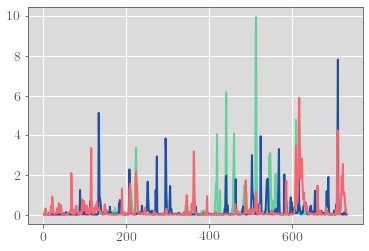

In [26]:
plt.plot(h4_ir.mean_indep[:, 0])
plt.plot(h4_ir.mean_indep[:, 1])
plt.plot(h4_ir.mean_indep[:, 2])

In [27]:
h4_ir_acc = h4_ir_acc[{"time": 0}]

In [28]:
h4_ir["surface_precip"] = h4_ir["mean_dep"]
h4_ir_acc["surface_precip_mean"] = h4_ir_acc["mean_dep"] / h4_ir_acc.attrs["files"]

In [29]:
h4_ir_dep_c = h4_ir[["mean_dep_c"]].copy().rename({"mean_dep_c": "surface_precip"})
h4_ir_dep_c_acc = h4_ir_acc[["mean_dep_c", "latitude", "longitude"]].copy().rename({"mean_dep_c": "surface_precip_acc"})
h4_ir_dep_c_acc["surface_precip_mean"] = h4_ir_dep_c_acc["surface_precip_acc"] / h4_ir_acc.attrs["files"]

In [30]:
h4_ir_indep_c = h4_ir[["mean_indep_c"]].copy().rename({"mean_indep_c": "surface_precip"})
h4_ir_indep_c_acc = h4_ir_acc[["mean_indep_c", "latitude", "longitude"]].copy().rename({"mean_indep_c": "surface_precip_acc"})
h4_ir_indep_c_acc["surface_precip_mean"] = h4_ir_indep_c_acc["surface_precip_acc"] / h4_ir_acc.attrs["files"]

## Gauge selection

Select gauges that have at least one sample and for which all retrieval produced output.

In [31]:
gauge_mask = ((h2_dep_c.surface_precip >= 0).any("time") *
              (imerg.surface_precip >= 0).any("time") *
              (persiann.surface_precip >= 0).any("time") *
              (gauges.surface_precip >= 0).mean("time") > 0.9)

In [32]:
gauges = gauges[{"gauges": gauge_mask}]
imerg = imerg[{"gauges": gauge_mask}]
persiann = persiann[{"gauges": gauge_mask}]
hydro = hydro[{"gauges": gauge_mask}]
h4_all = h4_all[{"gauges": gauge_mask}]
h4_all_dep_c = h4_all_dep_c[{"gauges": gauge_mask}]
h4_all_indep_c = h4_all_indep_c[{"gauges": gauge_mask}]
h4_ir = h4_ir[{"gauges": gauge_mask}]
h4_ir_dep_c = h4_ir_dep_c[{"gauges": gauge_mask}]
h4_indep_c = h4_ir_indep_c[{"gauges": gauge_mask}]
h2 = h2[{"gauges": gauge_mask}]
h2_dep_c = h2_dep_c[{"gauges": gauge_mask}]
h2_indep_c = h2_indep_c[{"gauges": gauge_mask}]

In [33]:
gauges.gauges.size

324

## Gauge overview

In [34]:
%env CARTOPY_USER_BACKGROUNDS=/home/simonpf/data/natural_earth/

env: CARTOPY_USER_BACKGROUNDS=/home/simonpf/data/natural_earth/


In [35]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

/tmp/ipykernel_21415/4157128883.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m, cax=ax, label="Number of gauges", orientation="horizontal")
/tmp/ipykernel_21415/4157128883.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(m, cax=ax, label="Mean precipitation [$\si{\milli \meter \per \hour}$]", orientation="horizontal", extend="min")


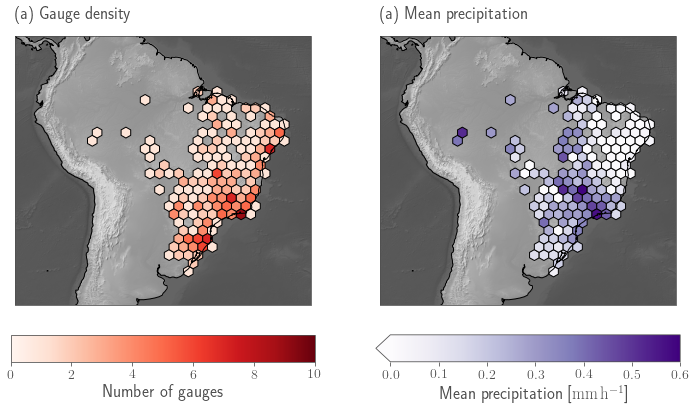

In [36]:
from copy import copy
from hydronn.definitions import ROI
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

lon_0, lat_0, lon_1, lat_1 = ROI

f = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, height_ratios=[1.0, 0.1])
ccs = ccrs.PlateCarree()
axs = np.array([f.add_subplot(gs[0, i], projection=ccs) for i in range(2)])

number_norm = Normalize(0, 10)
precip_norm = Normalize(0, 0.6)

ax = axs[0]
ax.background_img("ne_gray")
ax.coastlines()
lats = gauges.latitude.data
lons = gauges.longitude.data
sp = gauges.surface_precip.mean("time")
mask = np.ones_like(sp)
mask[np.isnan(sp)] = np.nan

m = ax.hexbin(lons, lats, mask, gridsize=20, edgecolors="k", linewidths=1, cmap="Reds",
              reduce_C_function=np.sum, norm=number_norm)
ax.set_xlim([lon_0, lon_1])
ax.set_ylim([lat_0, lat_1])
ax.set_title("(a) Gauge density", loc="left")

ax = f.add_subplot(gs[1, 0])
plt.colorbar(m, cax=ax, label="Number of gauges", orientation="horizontal")


ax = axs[1]
ax.background_img("ne_gray")
ax.coastlines()
lats = gauges.latitude.data
lons = gauges.longitude.data
cmap = copy(cm.get_cmap("Purples"))
m = ax.hexbin(lons, lats, sp, gridsize=20, edgecolors="k", linewidths=1, cmap=cmap,
              norm=precip_norm)
ax.set_xlim([lon_0, lon_1])
ax.set_ylim([lat_0, lat_1])
ax.set_title("(a) Mean precipitation", loc="left")

ax = f.add_subplot(gs[1, 1])
cb = plt.colorbar(m, cax=ax, label="Mean precipitation [$\si{\milli \meter \per \hour}$]", orientation="horizontal", extend="min")
cb.ax.set_facecolor((1.0, 1.0, 1.0, 1.0))

f.savefig("../plots/gauges.png", dpi=300)

## from matplotlib.colors import LogNorm
norm = LogNorm(1e-1, 1e1)
plt.pcolormesh(np.maximum(gauges.surface_precip, 1e-2), norm=norm)

/tmp/ipykernel_21415/2731483301.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(np.maximum(imerg.surface_precip, 1e-2), norm=norm)


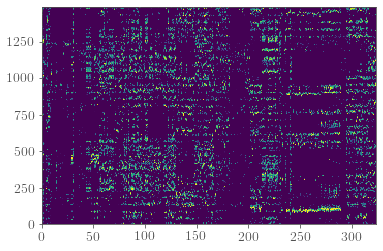

In [37]:
from matplotlib.colors import LogNorm
norm = LogNorm(1e-1, 1e1)
plt.pcolormesh(np.maximum(imerg.surface_precip, 1e-2), norm=norm)

/tmp/ipykernel_21415/2731483301.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(np.maximum(imerg.surface_precip, 1e-2), norm=norm)


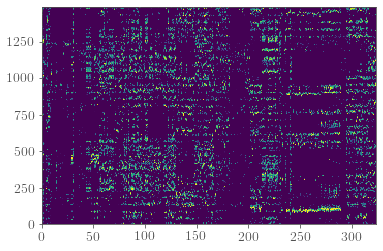

In [38]:
from matplotlib.colors import LogNorm
norm = LogNorm(1e-1, 1e1)
plt.pcolormesh(np.maximum(imerg.surface_precip, 1e-2), norm=norm)

/tmp/ipykernel_21415/2514516436.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(np.maximum(persiann.surface_precip, 1e-2), norm=norm)


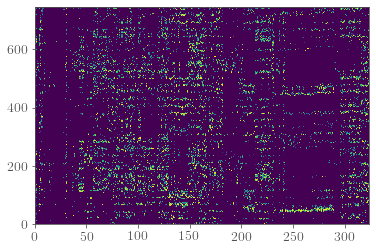

In [39]:
from matplotlib.colors import LogNorm
norm = LogNorm(1e-1, 1e1)
plt.pcolormesh(np.maximum(persiann.surface_precip, 1e-2), norm=norm)

/tmp/ipykernel_21415/1082845975.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(np.maximum(h2.surface_precip, 1e-2), norm=norm)


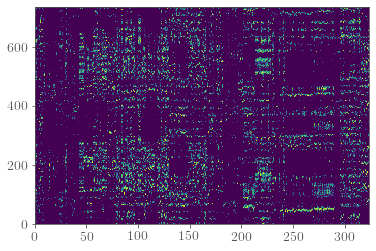

In [40]:
from matplotlib.colors import LogNorm
norm = LogNorm(1e-1, 1e1)
plt.pcolormesh(np.maximum(h2.surface_precip, 1e-2), norm=norm)

In [41]:
cmap.set_under("red")

## Mean precipitation

/tmp/ipykernel_21415/1980461498.py:72: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(m_acc, cax=ax, label="Mean precipitation [$\si{\milli \meter \per \hour}$]", orientation="horizontal")
/tmp/ipykernel_21415/1980461498.py:76: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m_bias, cax=ax, label="Bias [$\si{\milli \meter \per \hour}$]", orientation="horizontal")


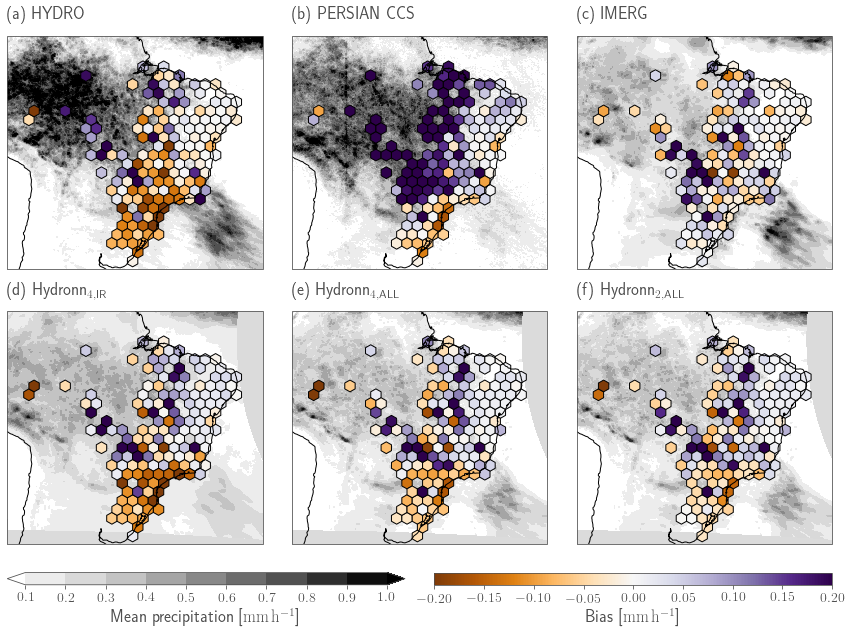

In [42]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

M = 2
N = 3
ccs = ccrs.PlateCarree()
f = plt.figure(figsize=(N * 4, M * 4 + 1))

gs = GridSpec((2 * M + 1), 2 * N, height_ratios = [1.0] * 2 * M + [0.1])
axs = np.array(
[[f.add_subplot(
    gs[2 * i: 2 * i + 2, 2 * j: 2 * j + 2], projection=ccs) for j in range(N)] for i in range(M)]
)

levels = np.linspace(0.1, 1.0, 10)
norm = Normalize(0, 1.0)
bias_norm = Normalize(-0.20, 0.20)
cmap = cm.get_cmap("Greys")

data = {
    "HYDRO": (hydro, hydro_acc),
    "PERSIAN CCS": (persiann, persiann_acc),
    "IMERG": (imerg, imerg_acc),
    r"Hydronn$_{4, \text{IR}}$": (h4_ir, h4_ir_acc),
    r"Hydronn$_{4, \text{ALL}}$": (h4_all, h4_all_acc),
    r"Hydronn$_{2, \text{ALL}}$": (h2, h2_acc),
}

lat_min = np.array([d[1].latitude.min() for d in data.values()])
lat_max = np.array([d[1].latitude.max() for d in data.values()])
lon_min = np.array([d[1].longitude.min() for d in data.values()])
lon_max = np.array([d[1].longitude.max() for d in data.values()])

lat_min[lat_min > 180] -= 360
lat_max[lat_max > 180] -= 360
lon_min[lon_min > 180] -= 360
lon_max[lon_max > 180] -= 360

lat_min = lat_min.max()
lat_max = lat_max.min()
lon_min = lon_min.max()
lon_max = lon_max.min()

for i, (title, (precip, acc)) in enumerate(data.items()):
    
    ax = axs[i // N, i % N]
    
    # Plot accumulations as background
    lons = acc.longitude.data
    lats = acc.latitude.data
    sp = acc.surface_precip_mean.data
    m_acc = ax.contourf(lons, lats, sp, norm=norm, cmap=cmap, levels=levels, extend="both")
    ax.coastlines()

    # Scatter biases
    sp_gauges = gauges.surface_precip.interp({"time": precip.time})
    sp = precip.surface_precip
    bias = (sp - sp_gauges).mean("time")
    total = sp_gauges.mean("time")
    total_r = sp.mean("time")

    lons = gauges.longitude.data
    lats = gauges.latitude.data
    m_bias = ax.hexbin(lons, lats, bias, gridsize=20, norm=bias_norm, cmap="PuOr", linewidths=1, edgecolors="k")
    
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_title(f"({chr(ord('a') + i)}) {title}", loc="left")

ax = f.add_subplot(gs[-1, :3])
cb = plt.colorbar(m_acc, cax=ax, label="Mean precipitation [$\si{\milli \meter \per \hour}$]", orientation="horizontal")
cb.ax.set_facecolor((1.0, 1.0, 1.0, 1.0))

ax = f.add_subplot(gs[-1, 3:])
plt.colorbar(m_bias, cax=ax, label="Bias [$\si{\milli \meter \per \hour}$]", orientation="horizontal")
plt.tight_layout()

f.savefig("../plots/mean_precipitation.png", dpi=300)

/tmp/ipykernel_21415/536186453.py:62: RuntimeWarning: invalid value encountered in true_divide
  bias = 100 * bias.data / (0.5 * (total_r.data + total.data))
/tmp/ipykernel_21415/536186453.py:73: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(m_acc, cax=ax, label="Mean precipitation [$\si{\milli \meter \per \hour}$]", orientation="horizontal")
/tmp/ipykernel_21415/536186453.py:77: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m_bias, cax=ax, label="Bias [$\si{\percent}$]", orientation="horizontal")


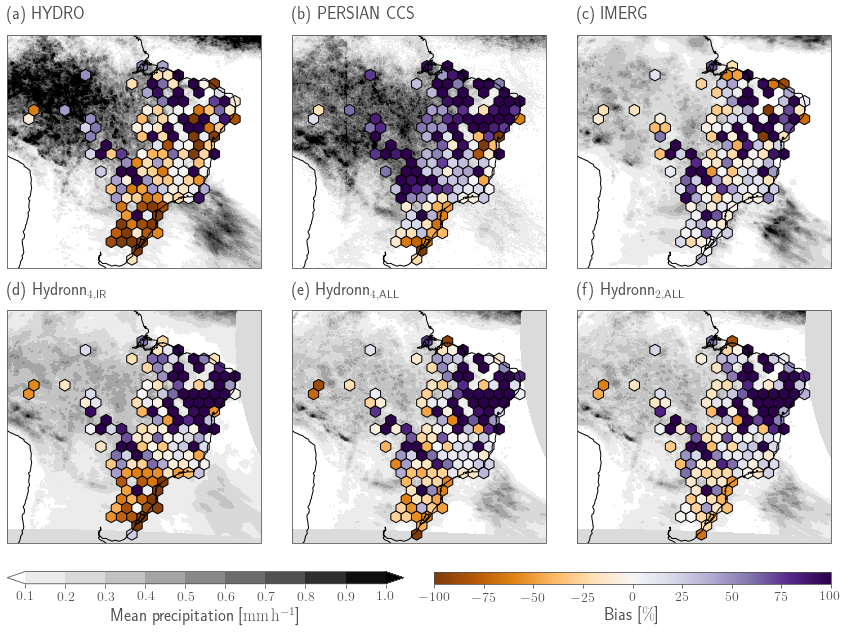

In [43]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

M = 2
N = 3
ccs = ccrs.PlateCarree()
f = plt.figure(figsize=(N * 4, M * 4 + 1))

gs = GridSpec((2 * M + 1), 2 * N, height_ratios = [1.0] * 2 * M + [0.1])
axs = np.array(
[[f.add_subplot(
    gs[2 * i: 2 * i + 2, 2 * j: 2 * j + 2], projection=ccs) for j in range(N)] for i in range(M)]
)

levels = np.linspace(0.1, 1.0, 10)
norm = Normalize(0, 1.0)
bias_norm = Normalize(-100, 100)
cmap = cm.get_cmap("Greys")

data = {
    "HYDRO": (hydro, hydro_acc),
    "PERSIAN CCS": (persiann, persiann_acc),
    "IMERG": (imerg, imerg_acc),
    r"Hydronn$_{4, \text{IR}}$": (h4_ir, h4_ir_acc),
    r"Hydronn$_{4, \text{ALL}}$": (h4_all, h4_all_acc),
    r"Hydronn$_{2, \text{ALL}}$": (h2, h2_acc),
}

lat_min = np.array([d[1].latitude.min() for d in data.values()])
lat_max = np.array([d[1].latitude.max() for d in data.values()])
lon_min = np.array([d[1].longitude.min() for d in data.values()])
lon_max = np.array([d[1].longitude.max() for d in data.values()])

lat_min[lat_min > 180] -= 360
lat_max[lat_max > 180] -= 360
lon_min[lon_min > 180] -= 360
lon_max[lon_max > 180] -= 360

lat_min = lat_min.max()
lat_max = lat_max.min()
lon_min = lon_min.max()
lon_max = lon_max.min()

for i, (title, (precip, acc)) in enumerate(data.items()):
    
    ax = axs[i // N, i % N]
    
    # Plot accumulations as background
    lons = acc.longitude.data
    lats = acc.latitude.data
    sp = acc.surface_precip_mean.data
    m_acc = ax.contourf(lons, lats, sp, norm=norm, cmap=cmap, levels=levels, extend="both")
    ax.coastlines()

    # Scatter biases
    sp_gauges = gauges.surface_precip.interp({"time": precip.time})
    sp = precip.surface_precip
    bias = (sp - sp_gauges).mean("time")
    total = sp_gauges.mean("time")
    total_r = sp.mean("time")
    bias = 100 * bias.data / (0.5 * (total_r.data + total.data))

    lons = gauges.longitude.data
    lats = gauges.latitude.data
    m_bias = ax.hexbin(lons, lats, bias, gridsize=20, norm=bias_norm, cmap="PuOr", linewidths=1, edgecolors="k")
    
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_title(f"({chr(ord('a') + i)}) {title}", loc="left")

ax = f.add_subplot(gs[-1, :3])
cb = plt.colorbar(m_acc, cax=ax, label="Mean precipitation [$\si{\milli \meter \per \hour}$]", orientation="horizontal")
cb.ax.set_facecolor((1.0, 1.0, 1.0, 1.0))

ax = f.add_subplot(gs[-1, 3:])
plt.colorbar(m_bias, cax=ax, label="Bias [$\si{\percent}$]", orientation="horizontal")
plt.tight_layout()

f.savefig("../plots/mean_precipitation_relative.png", dpi=300)

## Daily accumulations

/tmp/ipykernel_21415/3058982166.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(bins, bins, y.T, vmin=0.0, vmax=0.2, cmap="GnBu")
/tmp/ipykernel_21415/3058982166.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(bins, bins, y.T, vmin=0.0, vmax=0.2, cmap="GnBu")
/tmp/ipykernel_21415/3058982166.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(bins, bins, y.T, vmin=0.0, vmax=0.2, cmap="GnBu")
/tmp/ipykernel_21415/3058982166.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is depr

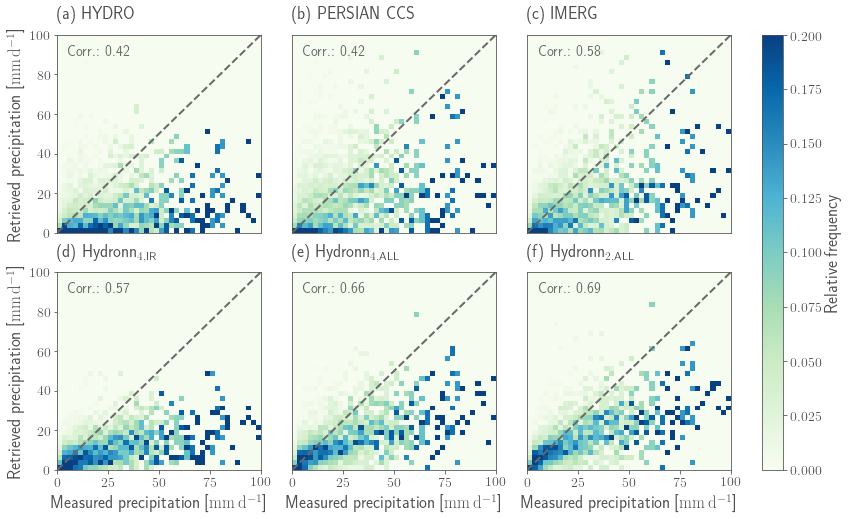

In [44]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from scipy.stats import linregress

M = 2
N = 3
f = plt.figure(figsize=(N * 4 + 1, M * 4))

gs = GridSpec(M, N + 1, width_ratios = [1.0] * N + [0.1])
axs = np.array(
[[f.add_subplot(
    gs[i, j]) for j in range(N)] for i in range(M)]
)

levels = np.linspace(0.1, 1.0, 9)
norm = Normalize(0, 1.0)
bias_norm = Normalize(-200, 200)
cmap = cm.get_cmap("Greys")

data = {
    "HYDRO": hydro,
    "PERSIAN CCS": persiann,
    "IMERG": imerg,
    r"Hydronn$_{4, \text{IR}}$": h4_ir,
    r"Hydronn$_{4, \text{ALL}}$": h4_all,
    r"Hydronn$_{2, \text{ALL}}$": h2,
}

bins = np.linspace(0, 100, 41)

for i, (title, precip) in enumerate(data.items()):
    
    ax = axs[i // N, i % N]
    
    # Plot accumulations as background
    precip_d = precip.resample(time="1d").mean()
    sp_gauges = gauges.surface_precip.resample(time="1d").mean()
    precip_d = precip_d.interp(time=sp_gauges.time)
    
    y, _, _ = np.histogram2d(sp_gauges.data.ravel() * 24,
                             precip_d.surface_precip.data.ravel() * 24,
                             bins=bins)
    y = y / y.sum(axis=1, keepdims=True)
    
    m = ax.pcolormesh(bins, bins, y.T, vmin=0.0, vmax=0.2, cmap="GnBu")
    ax.plot(bins, bins, c="dimgrey", ls="--")
    ax.set_title(f"({chr(ord('a') + i)}) {title}", loc="left")
    
    x = sp_gauges.data.ravel()
    y = precip_d.surface_precip.data.ravel()
    valid = x >= 0 #np.isfinite(x)
    slope, intercept, r, p, se = linregress(x[valid], y[valid])
    
    r = np.corrcoef(x=x[valid], y=y[valid])[0, 1]
    
    ax.text(s=f"Corr.: {r:2.2f}", x=5, y=90, color="dimgrey")
    
    if i % N == 0:
        ax.set_ylabel("Retrieved precipitation [$\si{\milli \meter \per \day}$]")
    else:
        ax.set_yticklabels([])
        for t in ax.yaxis.get_ticklines():
            t.set_visible(False)
    if i // N == 1:
        ax.set_xlabel("Measured precipitation [$\si{\milli \meter \per \day}$]")
    else:
        ax.set_xticklabels([])
        for t in ax.xaxis.get_ticklines():
            t.set_visible(False)
    
ax = f.add_subplot(gs[:, -1])
plt.colorbar(m, cax=ax, label="Relative frequency")
f.savefig("../plots/daily_accumulations.png", dpi=300)

/tmp/ipykernel_21415/2050331.py:50: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(bins, bins, y.T, vmin=0.0, vmax=0.2, cmap="GnBu")
/tmp/ipykernel_21415/2050331.py:50: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(bins, bins, y.T, vmin=0.0, vmax=0.2, cmap="GnBu")
/tmp/ipykernel_21415/2050331.py:50: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(bins, bins, y.T, vmin=0.0, vmax=0.2, cmap="GnBu")
/tmp/ipykernel_21415/2050331.py:50: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since

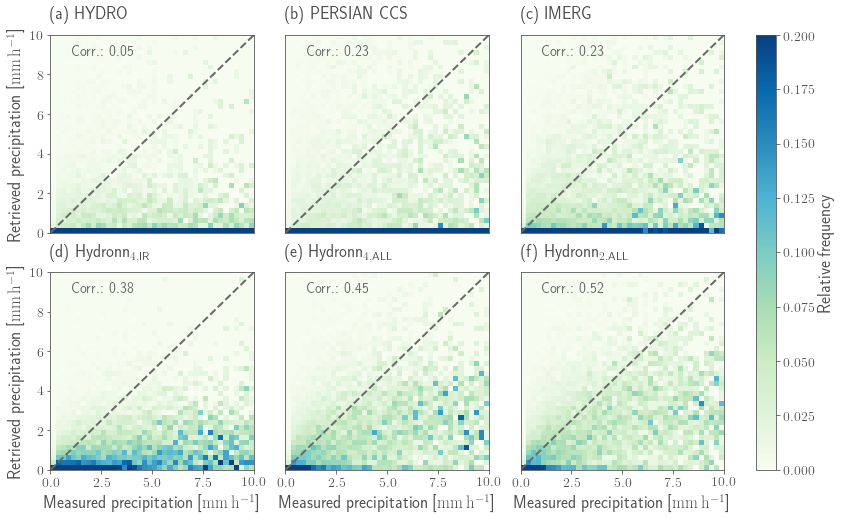

In [45]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from scipy.stats import linregress

M = 2
N = 3
f = plt.figure(figsize=(N * 4 + 1, M * 4))

gs = GridSpec(M, N + 1, width_ratios = [1.0] * N + [0.1])
axs = np.array(
[[f.add_subplot(
    gs[i, j]) for j in range(N)] for i in range(M)]
)

levels = np.linspace(0.1, 1.0, 9)
norm = Normalize(0, 1.0)
bias_norm = Normalize(-200, 200)
cmap = cm.get_cmap("Greys")

data = {
    "HYDRO": hydro,
    "PERSIAN CCS": persiann,
    "IMERG": imerg,
    r"Hydronn$_{4, \text{IR}}$": h4_ir,
    r"Hydronn$_{4, \text{ALL}}$": h4_all,
    r"Hydronn$_{2, \text{ALL}}$": h2,
}

bins = np.linspace(0, 10, 41)

for i, (title, precip) in enumerate(data.items()):
    
    ax = axs[i // N, i % N]
    
    # Plot accumulations as background
    precip_d = precip
    sp_gauges = gauges.surface_precip
    precip_d = precip_d.interp(time=sp_gauges.time)
    
    y, _, _ = np.histogram2d(sp_gauges.data.ravel(),
                             precip_d.surface_precip.data.ravel(),
                             bins=bins)
    db = np.diff(bins)
    a = db.reshape(-1, 1) * db.reshape(1, -1)
    y = y / a
    y = y / y.sum(axis=1, keepdims=True)
    
    
    m = ax.pcolormesh(bins, bins, y.T, vmin=0.0, vmax=0.2, cmap="GnBu")
    ax.plot(bins, bins, c="dimgrey", ls="--")
    ax.set_title(f"({chr(ord('a') + i)}) {title}", loc="left")
    
    x = sp_gauges.data.ravel()
    y = precip_d.surface_precip.data.ravel()
    
    valid = (x > 0.1) * (y > 0.1) #np.isfinite(x) 
    slope, intercept, r, p, se = linregress(x[valid], y[valid])
    ax.text(s=f"Corr.: {r:2.2f}", x=1, y=9, color="dimgrey")
    
    if i % N == 0:
        ax.set_ylabel("Retrieved precipitation [$\si{\milli \meter \per \hour}$]")
    else:
        ax.set_yticklabels([])
        for t in ax.yaxis.get_ticklines():
            t.set_visible(False)
    if i // N == 1:
        ax.set_xlabel("Measured precipitation [$\si{\milli \meter \per \hour}$]")
    else:
        ax.set_xticklabels([])
        for t in ax.xaxis.get_ticklines():
            t.set_visible(False)
    
ax = f.add_subplot(gs[:, -1])
plt.colorbar(m, cax=ax, label="Relative frequency")
f.savefig("../plots/hourly_accumulations.png", dpi=300)

## Error statistics

In [46]:
data = {
    "HYDRO": hydro,
    "PERSIANN CCS": persiann,
    "IMERG": imerg,
    "Hydronn$_{4, \text{IR}}$": h4_ir,
    "Hydronn$_{4, \text{All}}$": h4_all,
    "Hydronn$_{2, \text{All}}$": h2,
}

biases = {}
mse = {}
correlation = {}
smape = {}
mae = {}

for name, precip in data.items():
    sp_gauges = gauges.surface_precip.interp({"time": precip.time}).data
    sp = precip.surface_precip.data
    
    valid = (sp_gauges >= 0) * (sp >= 0)
    sp_gauges = sp_gauges[valid]
    sp = sp[valid]
    
    # Bias
    bias = sp - sp_gauges
    biases[name] = np.nanmean(bias)
    
    # Mean squared error
    ae = np.abs(sp - sp_gauges)
    mae[name] = np.nanmean(ae)
    
    # Mean squared error
    se = (sp - sp_gauges) ** 2
    mse[name] = np.nanmean(se)
    
    # Correlation
    s = np.stack([sp_gauges, sp])
    corr = np.corrcoef(s)[0, 1]
    correlation[name] = corr
    
    # SMAPE
    rel_err = ((sp - sp_gauges) /
               (0.5 * (np.abs(sp_gauges) + np.abs(sp))))
    rel_err = np.abs(rel_err[sp_gauges > 1e-1])
    smape[name] = np.mean(rel_err)
    
    

/tmp/ipykernel_21415/1032889977.py:42: RuntimeWarning: invalid value encountered in true_divide
  rel_err = ((sp - sp_gauges) /


In [47]:
import pandas as pd

results_h = pd.DataFrame({
    "Bias": biases.values(),
    "MAE": mae.values(),
    "MSE": mse.values(),
    "Correlation": correlation.values(),
},
    index=biases.keys()
)
results_h

Bias       MAE       MSE  Correlation
HYDRO                     -0.037684  0.307687  2.963916     0.133965
PERSIANN CCS               0.087546  0.382342  3.417400     0.260144
IMERG                      0.014830  0.275839  1.829340     0.379077
Hydronn$_{4, \text{IR}}$  -0.022866  0.277288  2.091107     0.411860
Hydronn$_{4, \text{All}}$  0.002102  0.247183  1.873582     0.501517
Hydronn$_{2, \text{All}}$  0.011268  0.239410  1.760074     0.544952

In [48]:
print(results_h.to_latex(float_format="%0.3f"), )

\begin{tabular}{lrrrr}
\toprule
{} &   Bias &   MAE &   MSE &  Correlation \\
\midrule
HYDRO                     & -0.038 & 0.308 & 2.964 &        0.134 \\
PERSIANN CCS              &  0.088 & 0.382 & 3.417 &        0.260 \\
IMERG                     &  0.015 & 0.276 & 1.829 &        0.379 \\
Hydronn\$\_\{4, \textbackslash text\{IR\}\}\$  & -0.023 & 0.277 & 2.091 &        0.412 \\
Hydronn\$\_\{4, \textbackslash text\{All\}\}\$ &  0.002 & 0.247 & 1.874 &        0.502 \\
Hydronn\$\_\{2, \textbackslash text\{All\}\}\$ &  0.011 & 0.239 & 1.760 &        0.545 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_21415/3083985113.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_h.to_latex(float_format="%0.3f"), )


### Daily

In [49]:
data = {
    "HYDRO": hydro,
    "PERSIANN CCS": persiann,
    "IMERG": imerg,
    "Hydronn$_{4, \text{IR}}$": h4_ir,
    "Hydronn$_{4, \text{All}}$": h4_all,
    "Hydronn$_{2, \text{All}}$": h2,
}

biases = {}
mse = {}
correlation = {}
smape = {}
mae = {}

for name, precip in data.items():
    sp_gauges = gauges.surface_precip.interp({"time": precip.time})
    sp_gauges = sp_gauges.resample(time="1d").mean().data
    sp = precip.surface_precip.resample(time="1d").mean().data
    
    
    valid = (sp_gauges >= 0) * (sp >= 0)
    sp_gauges = sp_gauges[valid]
    sp = sp[valid]
    
    # Bias
    bias = sp - sp_gauges
    biases[name] = np.nanmean(bias)
    
    # Mean squared error
    ae = np.abs(sp - sp_gauges)
    mae[name] = np.nanmean(ae)
    
    # Mean squared error
    se = (sp - sp_gauges) ** 2
    mse[name] = np.nanmean(se)
    
    # Correlation
    s = np.stack([sp_gauges, sp])
    corr = np.corrcoef(s)[0, 1]
    correlation[name] = corr
    
    # SMAPE
    rel_err = ((sp - sp_gauges) /
               (0.5 * (np.abs(sp_gauges) + np.abs(sp))))
    rel_err = np.abs(rel_err[sp_gauges > 1e-1])
    smape[name] = np.mean(rel_err)
    
    

/tmp/ipykernel_21415/2936503860.py:44: RuntimeWarning: invalid value encountered in true_divide
  rel_err = ((sp - sp_gauges) /
/tmp/ipykernel_21415/2936503860.py:44: RuntimeWarning: invalid value encountered in true_divide
  rel_err = ((sp - sp_gauges) /
/tmp/ipykernel_21415/2936503860.py:44: RuntimeWarning: invalid value encountered in true_divide
  rel_err = ((sp - sp_gauges) /


In [50]:
import pandas as pd

results_d = pd.DataFrame({
    "Bias": biases.values(),
    "MAE": mae.values(),
    "MSE": mse.values(),
    "Correlation": correlation.values(),
},
    index=biases.keys()
)
results_d

Bias       MAE       MSE  Correlation
HYDRO                     -0.037345  0.208230  0.211723     0.421436
PERSIANN CCS               0.089006  0.273665  0.292920     0.414623
IMERG                      0.016517  0.190588  0.178145     0.574464
Hydronn$_{4, \text{IR}}$  -0.022942  0.191272  0.163449     0.573484
Hydronn$_{4, \text{All}}$  0.002641  0.167550  0.135229     0.662358
Hydronn$_{2, \text{All}}$  0.011672  0.161788  0.128086     0.685179

In [51]:
print(results_d.to_latex(float_format="%0.3f"), )

\begin{tabular}{lrrrr}
\toprule
{} &   Bias &   MAE &   MSE &  Correlation \\
\midrule
HYDRO                     & -0.037 & 0.208 & 0.212 &        0.421 \\
PERSIANN CCS              &  0.089 & 0.274 & 0.293 &        0.415 \\
IMERG                     &  0.017 & 0.191 & 0.178 &        0.574 \\
Hydronn\$\_\{4, \textbackslash text\{IR\}\}\$  & -0.023 & 0.191 & 0.163 &        0.573 \\
Hydronn\$\_\{4, \textbackslash text\{All\}\}\$ &  0.003 & 0.168 & 0.135 &        0.662 \\
Hydronn\$\_\{2, \textbackslash text\{All\}\}\$ &  0.012 & 0.162 & 0.128 &        0.685 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_21415/922752898.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_d.to_latex(float_format="%0.3f"), )


### Monthly

In [52]:
data = {
    "PERSIANN CCS": persiann,
    "IMERG": imerg,
    "HYDRO": hydro,
    "Hydronn$_{4, \text{IR}}$": h4_ir,
    "Hydronn$_{4, \text{All}}$": h4_all,
    "Hydronn$_{2, \text{All}}$": h2,
}

biases = {}
mse = {}
correlation = {}
smape = {}
mae = {}

for name, precip in data.items():
    sp_gauges = gauges.surface_precip.interp({"time": precip.time})
    sp_gauges = sp_gauges.resample(time="1m").mean().data
    sp = precip.surface_precip.resample(time="1m").mean().data
    
    
    valid = (sp_gauges >= 0) * (sp >= 0)
    sp_gauges = sp_gauges[valid]
    sp = sp[valid]
    
    # Bias
    bias = sp - sp_gauges
    biases[name] = np.nanmean(bias)
    
    # Mean squared error
    ae = np.abs(sp - sp_gauges)
    mae[name] = np.nanmean(ae)
    
    # Mean squared error
    se = (sp - sp_gauges) ** 2
    mse[name] = np.nanmean(se)
    
    # Correlation
    s = np.stack([sp_gauges, sp])
    corr = np.corrcoef(s)[0, 1]
    correlation[name] = corr
    
    # SMAPE
    rel_err = ((sp - sp_gauges) /
               (0.5 * (np.abs(sp_gauges) + np.abs(sp))))
    rel_err = np.abs(rel_err[sp_gauges > 1e-1])
    smape[name] = np.mean(rel_err)
    
    

/tmp/ipykernel_21415/2031274558.py:44: RuntimeWarning: invalid value encountered in true_divide
  rel_err = ((sp - sp_gauges) /


In [53]:
import pandas as pd

results_m = pd.DataFrame({
    "Bias": biases.values(),
    "MAE": mae.values(),
    "MSE": mse.values(),
    "Correlation": correlation.values(),
},
    index=biases.keys()
)
results_m

Bias       MAE       MSE  Correlation
PERSIANN CCS               0.089547  0.144071  0.039956     0.553236
IMERG                      0.017111  0.077169  0.013457     0.740613
HYDRO                     -0.036148  0.104287  0.019248     0.629466
Hydronn$_{4, \text{IR}}$  -0.021801  0.095835  0.017485     0.650159
Hydronn$_{4, \text{All}}$  0.003576  0.080736  0.013864     0.730530
Hydronn$_{2, \text{All}}$  0.012595  0.075219  0.012834     0.755536

In [54]:
print(results_m.to_latex(float_format="%0.3f"), )

\begin{tabular}{lrrrr}
\toprule
{} &   Bias &   MAE &   MSE &  Correlation \\
\midrule
PERSIANN CCS              &  0.090 & 0.144 & 0.040 &        0.553 \\
IMERG                     &  0.017 & 0.077 & 0.013 &        0.741 \\
HYDRO                     & -0.036 & 0.104 & 0.019 &        0.629 \\
Hydronn\$\_\{4, \textbackslash text\{IR\}\}\$  & -0.022 & 0.096 & 0.017 &        0.650 \\
Hydronn\$\_\{4, \textbackslash text\{All\}\}\$ &  0.004 & 0.081 & 0.014 &        0.731 \\
Hydronn\$\_\{2, \textbackslash text\{All\}\}\$ &  0.013 & 0.075 & 0.013 &        0.756 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_21415/1505125782.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_m.to_latex(float_format="%0.3f"), )


In [55]:
results_h.reset_index?

In [56]:
results_h["Accumulation"] = "Hourly"
results_d["Accumulation"] = "Daily"
results_m["Accumulation"] = "Monthly"
columns = {"index": "Retrieval"}
results = pd.concat([
    results_h.reset_index().rename(columns=columns),
    results_d.reset_index().rename(columns=columns),
    results_m.reset_index().rename(columns=columns)
])
results
results["RMSE"] = np.sqrt(results["MSE"])

In [57]:
import seaborn as sns
sns.reset_orig()

In [58]:
sns.dark_palette("C0", 5)

[(0.13685337041646825, 0.1512985754788912, 0.14250033504834625),
 (0.19600835688018586, 0.32099957122182843, 0.2573237803695456),
 (0.2551633433439035, 0.4907005669647657, 0.372147225690745),
 (0.3143183298076211, 0.6604015627077029, 0.48697067101194436),
 (0.37254901960784315, 0.8274509803921568, 0.6)]

In [59]:
colors = (sns.dark_palette("deepskyblue", 4)[1:] +
          sns.dark_palette("C0", 4)[1:])

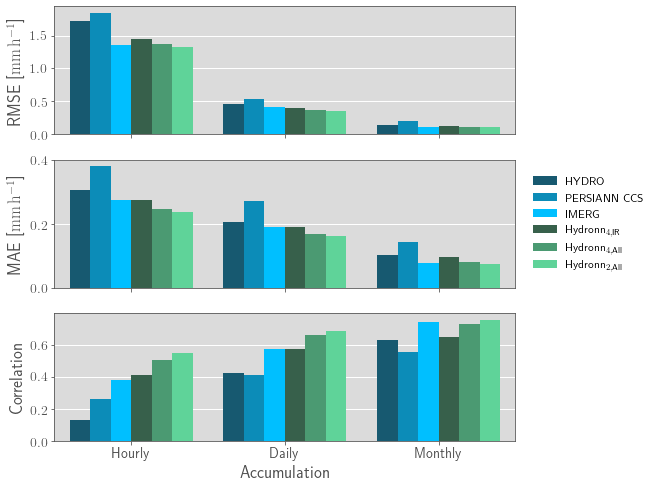

In [60]:
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 2, width_ratios=[1.0, 0.1])

ax = f.add_subplot(gs[0, 0])
g = sns.barplot(data=results, x="Accumulation", y="RMSE", hue="Retrieval", ax=ax, palette=colors, saturation=1.0)
g.legend_.set_visible(False)
ax.set_xlabel("")
for l in ax.get_xticklabels():
    l.set_visible(False)
ax.set_ylabel("RMSE [$\si{\milli \meter \per \hour}$]")

ax = f.add_subplot(gs[1, 0])
g = sns.barplot(data=results, x="Accumulation", y="MAE", hue="Retrieval", ax=ax, palette=colors, saturation=1.0)
g.legend_.set_visible(False)
ax.set_xlabel("")
for l in ax.get_xticklabels():
    l.set_visible(False)
ax.set_ylabel("MAE [$\si{\milli \meter \per \hour}$]")

ax = f.add_subplot(gs[2, 0])
g = sns.barplot(data=results, x="Accumulation", y="Correlation", hue="Retrieval", ax=ax, palette=colors, saturation=1.0)
g.legend_.set_visible(False)

ax = f.add_subplot(gs[:, -1])
ax.set_axis_off()
patches = g.legend_.get_patches()
names = ["HYDRO", "PERSIANN CCS", "IMERG", r"Hydronn$_{4, \text{IR}}$", r"Hydronn$_{4, \text{All}}$", r"Hydronn$_{2, \text{All}}$",]
ax.legend(labels=names, handles=patches, loc="center")

f.savefig("../plots/metrics.pdf")

In [61]:
g.legend_.get_patches()

<a list of 6 Patch objects>

### Daily cycle

In [62]:
def calculate_daily_cycle(data):
    """
    Calculate the daily cycle.
    
    This function first interpolates the given dataset to the time of the gauge measurements
    to account for missing times. Then it calculates for each gauge the daily cycle. Only
    measurements that are not missing in the gauges measurements are included.
    
    Args:
        data: xarray.Dataset with a 'surface_precip' variable that contains the retrieved precipitation
             for each gauge.
             
    Return:
        Tuple ``(h, precip)`` containing the hours ``x`` and the corresponding mean precipitation
        ``precip``.
    """
    bins = np.arange(25) - 0.5
    
    data_g = data.interp(time=gauges.time)
    data_g["solar_time"] = data_g.time + ((24 * 3600) * gauges.longitude / 360.0).astype("timedelta64[s]")
    solar_time = data_g.solar_time
    
    valid = (data_g.surface_precip.data >= 0.0) * (gauges.surface_precip.data >= 0.0)
    
    hours = solar_time.dt.hour.data[valid]
    precip = data_g.surface_precip.data[valid]
    
    precip_acc, _ = np.histogram(hours, weights=precip, bins=bins)
    precip_counts, _ = np.histogram(hours, bins=bins)
    
    x = 0.5 * (bins[1:] + bins[:-1])
    return x, precip_acc / precip_counts

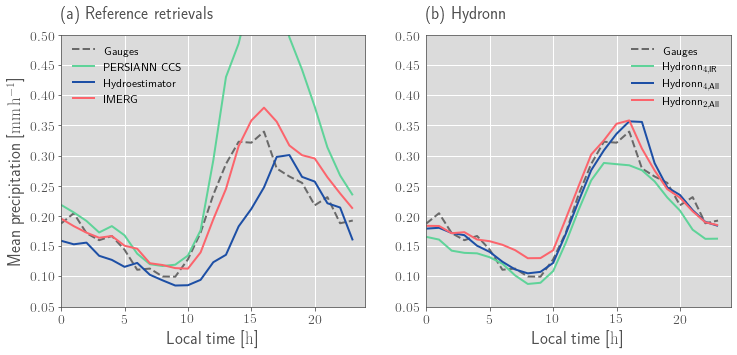

In [63]:
means = {}

f = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2)
axs = [f.add_subplot(gs[i]) for i in range(2)]

data_1 = {
    "PERSIANN CCS": persiann,
    "Hydroestimator": hydro,
    "IMERG": imerg,
}

data_2 = {
    r"Hydronn$_{4, \text{IR}}$": h4_ir,
    r"Hydronn$_{4, \text{All}}$": h4_all,
    r"Hydronn$_{2, \text{All}}$": h2,
}

#
# Reference retrievals
#

ax = axs[0]
ax.set_title("(a) Reference retrievals", loc="left")
x, y = calculate_daily_cycle(gauges)
ax.plot(x, y, label="Gauges", ls="--", c="dimgrey")

for name, data in data_1.items():
    x, y = calculate_daily_cycle(data)
    ax.plot(x, y, label=name)
    ax.legend()
ax.set_xlim([0, 24])
ax.set_ylim([0.05, 0.5])

ax.set_xlabel("Local time [$\si{\hour}$]")
ax.set_ylabel("Mean precipitation [$\si{\milli \meter \per \hour}$]")

#
# Hydronn
#

ax = axs[1]
ax.set_title("(b) Hydronn", loc="left")
x, y = calculate_daily_cycle(gauges)
ax.plot(x, y, label="Gauges", ls="--", c="dimgrey")

for name, data in data_2.items():
    x, y = calculate_daily_cycle(data)
    ax.plot(x, y, label=name)
    ax.legend()
    
ax.set_xlim([0, 24])
ax.set_ylim([0.05, 0.5])
ax.set_xlabel("Local time [$\si{\hour}$]")
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)
    
f.savefig("../plots/daily_cycle.pdf")

## Rain rate distrbution

In [64]:
bins = np.concatenate([0.2 * np.arange(10) - 0.1,
                       2.1 + 2.0 * np.arange(50)])

def calculate_precip_distributions(data, variable="surface_precip"):
    """
    """
    data_g = data.interp(time=gauges.time)
    valid = (data_g[variable].data >= 0.0) * (gauges.surface_precip.data >= 0.0)
    
    precip = data_g[variable].data[valid]
    
    y, _ = np.histogram(precip, bins=bins, density=True)
    x = 0.5 * (bins[1:] + bins[:-1])
    return x, y

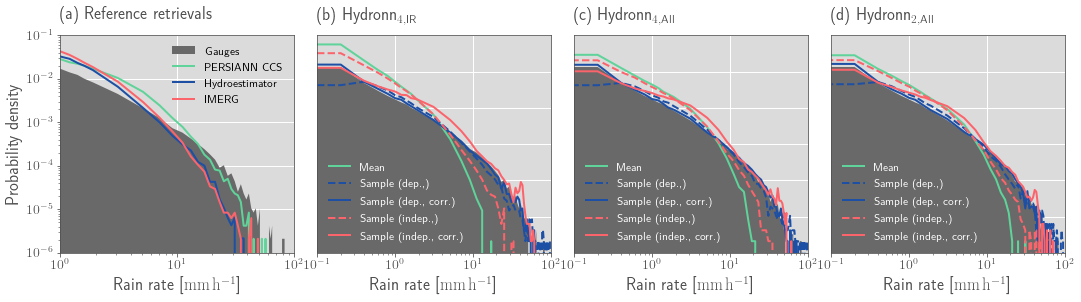

In [65]:
f = plt.figure(figsize=(18, 4))
gs = GridSpec(1, 4, wspace=0.10)
axs = [f.add_subplot(gs[i]) for i in range(4)]

data = {
    "PERSIANN CCS": persiann,
    "Hydroestimator": hydro,
    "IMERG": imerg,
}


#
# Reference retrievals
#

ax = axs[0]
ax.set_title("(a) Reference retrievals", loc="left")
x, y = calculate_precip_distributions(gauges)
ax.fill_between(x, y, label="Gauges", ls="--", facecolor="dimgrey")

for name, data in data.items():
    x, y = calculate_precip_distributions(data)
    ax.plot(x, y, label=name)
ax.legend()
ax.set_xlim([1e-1, 1e2])
ax.set_ylim([1e-6, 1e-1])
ax.set_yscale("log")

ax.set_xlabel("Rain rate [$\si{\milli \meter \per \hour}$]")
ax.set_ylabel("Probability density")

ax.set_xlim([1e0, 1e2])
ax.set_ylim([1e-6, 1e-1])
ax.set_yscale("log")
ax.set_xscale("log")

#
# Hydronn 4 IR
#

ax = axs[1]
ax.set_title(r"(b) Hydronn$_{4, \text{IR}}$", loc="left")

x, y = calculate_precip_distributions(gauges)
ax.fill_between(x, y, ls="--", facecolor="dimgrey")

# Mean
x, y = calculate_precip_distributions(h4_ir, "surface_precip")
ax.plot(x, y, label= "Mean", c="C0")

# Sample dep.
x, y = calculate_precip_distributions(h4_ir, "sample_dep")
ax.plot(x, y, label= "Sample (dep.,)", ls="--", c="C1")

# Sample dep., corr.
x, y = calculate_precip_distributions(h4_ir, "sample_dep_c")
ax.plot(x, y, label= "Sample (dep., corr.)", ls="-", c="C1")

# Sample dep.
x, y = calculate_precip_distributions(h4_ir, "sample_indep")
ax.plot(x, y, label= "Sample (indep.,)", ls="--", c="C2")

# Sample dep., corr.
x, y = calculate_precip_distributions(h4_ir, "sample_indep_c")
ax.plot(x, y, label= "Sample (indep., corr.)", ls="-", c="C2")
    
ax.set_xlim([1e-1, 1e2])
ax.set_ylim([1e-6, 1e0])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Rain rate [$\si{\milli \meter \per \hour}$]")
l = ax.legend()
plt.setp(l.get_texts(), color='w')

ax.set_yticklabels([])
for l in ax.yaxis.get_minorticklines():
    l.set_visible(False)
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)

#
# Hydronn 4 All
#

ax = axs[2]
ax.set_title(r"(c) Hydronn$_{4, \text{All}}$", loc="left")

x, y = calculate_precip_distributions(gauges)
ax.fill_between(x, y, ls="--", facecolor="dimgrey")

# Mean
x, y = calculate_precip_distributions(h4_all, "surface_precip")
ax.plot(x, y, label= "Mean", c="C0")

# Sample dep.
x, y = calculate_precip_distributions(h4_all, "sample_dep")
ax.plot(x, y, label= "Sample (dep.,)", ls="--", c="C1")

# Sample dep., corr.
x, y = calculate_precip_distributions(h4_all, "sample_dep_c")
ax.plot(x, y, label= "Sample (dep., corr.)", ls="-", c="C1")

# Sample dep.
x, y = calculate_precip_distributions(h4_all, "sample_indep")
ax.plot(x, y, label= "Sample (indep.,)", ls="--", c="C2")

# Sample dep., corr.
x, y = calculate_precip_distributions(h4_all, "sample_indep_c")
ax.plot(x, y, label= "Sample (indep., corr.)", ls="-", c="C2")
    
ax.set_xlim([1e-1, 1e2])
ax.set_ylim([1e-6, 1e0])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Rain rate [$\si{\milli \meter \per \hour}$]")
l = ax.legend()
plt.setp(l.get_texts(), color='w')

ax.set_yticklabels([])
for l in ax.yaxis.get_minorticklines():
    l.set_visible(False)
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)

#
# Hydronn 2 All
#

ax = axs[3]
ax.set_title(r"(d) Hydronn$_{2, \text{All}}$", loc="left")

x, y = calculate_precip_distributions(gauges)
ax.fill_between(x, y, ls="--", facecolor="dimgrey")

# Mean
x, y = calculate_precip_distributions(h2, "surface_precip")
ax.plot(x, y, label= "Mean", c="C0")

# Sample dep.
x, y = calculate_precip_distributions(h2, "sample_dep")
ax.plot(x, y, label= "Sample (dep.,)", ls="--", c="C1")

# Sample dep., corr.
x, y = calculate_precip_distributions(h2, "sample_dep_c")
ax.plot(x, y, label= "Sample (dep., corr.)", ls="-", c="C1")

# Sample dep.
x, y = calculate_precip_distributions(h2, "sample_indep")
ax.plot(x, y, label= "Sample (indep.,)", ls="--", c="C2")

# Sample dep., corr.
x, y = calculate_precip_distributions(h2, "sample_indep_c")
ax.plot(x, y, label= "Sample (indep., corr.)", ls="-", c="C2")
    
ax.set_xlim([1e-1, 1e2])
ax.set_ylim([1e-6, 1e0])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Rain rate [$\si{\milli \meter \per \hour}$]")
l = ax.legend()
plt.setp(l.get_texts(), color='w')

ax.set_yticklabels([])
for l in ax.yaxis.get_minorticklines():
    l.set_visible(False)
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)

f.savefig("../plots/rain_rate_distributions.pdf")

## Calibration of quantiles and confidence intervals


In [66]:
from hydronn.utils import adapt_gauge_precip

def calculate_calibration(quantiles, adapt=True):
    """
    Calculate calibration of confidence intervals.
    
    Calculates the observed frequencies with wich a gauge measurement lies within a predicted
    confidence interval.
    
    Args:
        quantiles: xarray.DataArray containing the predicted quantiles.
        
    Return:
        A tuple ``(f_nom, f)`` containing the array ``f_nom`` of nominal, i.e. expected,
        frequencies and observed frequenecies ``f``.
    """
    
    f_nom = []
    f = []
    
    if adapt:
        y_true = adapt_gauge_precip(gauges.surface_precip.interp({"time": quantiles.time}).data)
    else:
        y_true = gauges.surface_precip.interp({"time": quantiles.time}).data
    valid = y_true >= 0.0
    y_true = y_true[valid]
    
    for i in range(6):
        qs = quantiles.data[valid, i].copy()
        f.append(((y_true >= qs) * (y_true <= quantiles.data[valid, -(i + 2)])).mean())
        f_nom.append(quantiles.quantiles[-(i + 2)] - quantiles.quantiles[i])
        
    return np.array(f_nom), np.array(f)

In [67]:
from hydronn.utils import adapt_gauge_precip

def calculate_calibration(quantiles):
    """
    Calculate calibration of quantiles.
    
    Calculates the observed frequencies with wich a gauge measurement lies below a predicted
    quantile.
    
    Args:
        quantiles: xarray.DataArray containing the predicted quantiles.
        
    Return:
        A tuple ``(f_nom, f)`` containing the array ``f_nom`` of nominal, i.e. expected,
        frequencies and observed frequenecies ``f``.
    """
    
    f_nom = []
    f = []
    
    y_true = adapt_gauge_precip(gauges.surface_precip.interp({"time": quantiles.time}).data)
    valid = y_true >= 0.0
    y_true = y_true[valid]
    
    for i in range(14):
        qs = quantiles.data[valid, i].copy()
        f.append((y_true < quantiles.data[valid, i]).mean())
        f_nom.append(quantiles.quantiles[i])
        
    return np.array(f_nom), np.array(f)

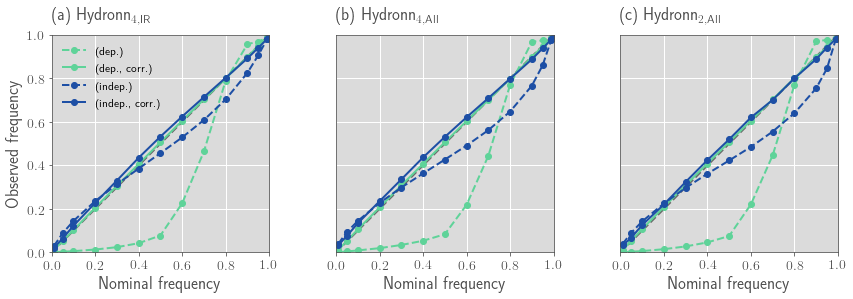

In [68]:
f = plt.figure(figsize=(15, 4))
gs = GridSpec(1, 3, wspace=0.06)
axs = [f.add_subplot(gs[i]) for i in range(3)]


#
# Hydronn 4 IR
#

ax = axs[0]
ax.set_title(r"(a) Hydronn$_{4, \text{IR}}$", loc="left")

x = np.linspace(0, 1, 21)
ax.plot(x, x, ls="--", c="dimgrey")

# dep.
x, y = calculate_calibration(h4_ir.quantiles_dep)
ax.plot(x, y, label= "(dep.)", c="C0", ls="--", marker="o")


# dep. corr.
x, y = calculate_calibration(h4_ir.quantiles_dep_c)
ax.plot(x, y, label= "(dep., corr.)", c="C0", marker="o")

# indep.
x, y = calculate_calibration(h4_ir.quantiles_indep)
ax.plot(x, y, label= "(indep.)", c="C1", ls="--", marker="o")

# indep. corr.
x, y = calculate_calibration(h4_ir.quantiles_indep_c)
ax.plot(x, y, label= "(indep., corr.)", c="C1", marker="o")
    
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect(1.0)
ax.set_ylabel("Observed frequency")
ax.set_xlabel("Nominal frequency")
ax.legend()


#
# Hydronn 4 All
#

ax = axs[1]
ax.set_title(r"(b) Hydronn$_{4, \text{All}}$", loc="left")
x = np.linspace(0, 1, 21)
ax.plot(x, x, ls="--", c="dimgrey")
# dep.
x, y = calculate_calibration(h4_all.quantiles_dep)
ax.plot(x, y, label= "(dep.)", c="C0", ls="--", marker="o")
# dep. corr.
x, y = calculate_calibration(h4_all.quantiles_dep_c)
ax.plot(x, y, label= "(dep., corr.)", c="C0", marker="o")
# indep.
x, y = calculate_calibration(h4_all.quantiles_indep)
ax.plot(x, y, label= "(indep.)", c="C1", ls="--", marker="o")
# indep. corr.
x, y = calculate_calibration(h4_all.quantiles_indep_c)
ax.plot(x, y, label= "(indep., corr.)", c="C1", marker="o")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect(1.0)
ax.set_xlabel("Nominal frequency")

ax.set_yticklabels([])
for l in ax.yaxis.get_minorticklines():
    l.set_visible(False)
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)
    
#
# Hydronn 2 All
#

ax = axs[2]
ax.set_title(r"(c) Hydronn$_{2, \text{All}}$", loc="left")
x = np.linspace(0, 1, 21)
ax.plot(x, x, ls="--", c="dimgrey")
# dep.
x, y = calculate_calibration(h2.quantiles_dep)
ax.plot(x, y, label= "(dep.)", c="C0", ls="--", marker="o")
# dep. corr.
x, y = calculate_calibration(h2.quantiles_dep_c)
ax.plot(x, y, label= "(dep., corr.)", c="C0", marker="o")
# indep.
x, y = calculate_calibration(h2.quantiles_indep)
ax.plot(x, y, label= "(indep.,)", c="C1", ls="--", marker="o")
# indep. corr.
x, y = calculate_calibration(h2.quantiles_indep_c)
ax.plot(x, y, label= "(indep., corr.)", c="C1", marker="o")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect(1.0)
ax.set_xlabel("Nominal frequency")

ax.set_yticklabels([])
for l in ax.yaxis.get_minorticklines():
    l.set_visible(False)
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)

f.savefig("../plots/calibration.pdf")

## Detection of extreme precip

### ROC curves

In [69]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve
from quantnn.quantiles import probability_larger_than

def calculate_roc_curve(data, threshold, variable="surface_precip"):
    data_g = data.interp(time=gauges.time)
    valid = (data_g[variable].data >= 0.0) * (gauges.surface_precip.data >= 0.0)
    
    truth = gauges.surface_precip.data[valid] > threshold
    sp = data_g[variable].data[valid]
    tp, fp, _ = roc_curve(truth, sp)
    return tp, fp

def calculate_pr_curve(data, threshold, variable="surface_precip"):
    data_g = data.interp(time=gauges.time)
    valid = (data_g[variable].data >= 0.0) * (gauges.surface_precip.data >= 0.0)
    
    truth = gauges.surface_precip.data[valid] > threshold
    sp = data_g[variable].data[valid]
    pr, rc, _ = precision_recall_curve(truth, sp)
    return pr, rc

def calculate_pr_curve_naive(threshold):
    valid = (gauges.surface_precip.data >= 0.0)
    truth = gauges.surface_precip.data[valid] > threshold
    p = np.ones_like(truth) * (gauges.surface_precip.data[valid] > threshold).mean()
    pr, rc, _ = precision_recall_curve(truth, p)
    return pr, rc
    
def calculate_roc_curve_hydronn(data, threshold, variable="surface_precip"):
    data_g = data.interp(time=gauges.time)
    valid = (data_g["mean_dep"].data >= 0.0) * (gauges.surface_precip.data >= 0.0)
    p = probability_larger_than(
        data_g[variable].data[valid],
        data_g.quantiles.data,
        threshold,
        quantile_axis=-1
    )
    truth = gauges.surface_precip.data[valid] > threshold
    fp, tp, _ = roc_curve(truth, p)
    return fp, tp 
    
def calculate_pr_curve_hydronn(data, threshold, variable="surface_precip"):
    data_g = data.interp(time=gauges.time)
    valid = (data_g["mean_dep"].data >= 0.0) * (gauges.surface_precip.data >= 0.0)
    p = probability_larger_than(
        data_g[variable].data[valid],
        data_g.quantiles.data,
        threshold,
        quantile_axis=-1
    )
    truth = gauges.surface_precip.data[valid] > threshold
    pr, rc, _ = precision_recall_curve(truth, p)
    return pr, rc 

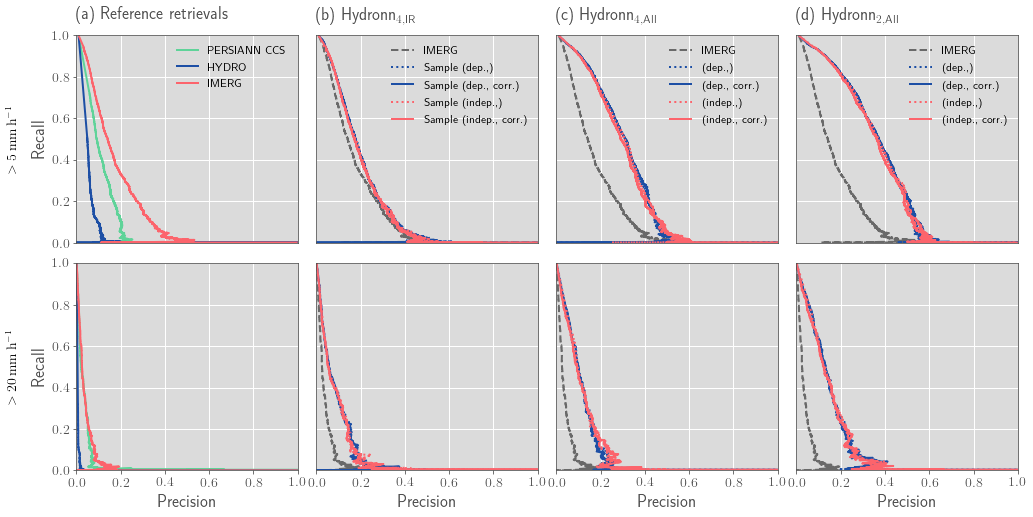

In [70]:
f = plt.figure(figsize=(18, 8))
gs = GridSpec(2, 5, wspace=0.1, hspace=0.1, width_ratios = [0.20] + 4 * [1.0])
axs = np.array([[f.add_subplot(gs[i, 1 + j]) for j in range(4)] for i in range(2)])

data = {
    "PERSIANN CCS": persiann,
    "HYDRO": hydro,
    "IMERG": imerg,
}

#
# Reference retrievals
#

THRESHS = [5, 20]

for i, thresh in enumerate(THRESHS):
    
    ax = f.add_subplot(gs[i, 0])
    ax.text(
        x=0, y=0,
        s=f"$> \SI{{{thresh}}}{{\milli \meter \per \hour}}$",
        rotation=90,
        ha="center",
        va="center",
        fontsize=14
    )
    ax.set_axis_off()
    ax.set_ylim([-1, 1])

    ax = axs[i, 0]
    

    for name, d in data.items():
        x, y = calculate_pr_curve(d, thresh)
        ax.plot(x, y, label=name)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    if i == 1:
        ax.set_xlabel("Precision")
    else:
        ax.legend(loc="upper right")
        ax.set_title("(a) Reference retrievals", loc="left")
        ax.set_xticklabels([])
        for l in ax.xaxis.get_minorticklines():
            l.set_visible(False)
        for l in ax.xaxis.get_ticklines():
            l.set_visible(False)
    ax.set_ylabel("Recall")
    
    #
    # Hydronn 4 IR
    #
    
    ax = axs[i, 1]
    
    

    x, y = calculate_pr_curve(imerg, thresh)
    ax.plot(x, y, label= "IMERG", ls="--", c="dimgrey")

    # Sample dep.
    x, y = calculate_pr_curve_hydronn(h4_ir, thresh, "quantiles_dep")
    ax.plot(x, y, label= "Sample (dep.,)", ls=":", c="C1")

    # Sample dep., corr.
    x, y = calculate_pr_curve_hydronn(h4_ir, thresh, "quantiles_dep_c")
    ax.plot(x, y, label= "Sample (dep., corr.)", ls="-", c="C1")

    # Sample dep.
    x, y = calculate_pr_curve_hydronn(h4_ir, thresh, "quantiles_indep")
    ax.plot(x, y, label= "Sample (indep.,)", ls=":", c="C2")

    # Sample dep., corr.
    x, y = calculate_pr_curve_hydronn(h4_ir, thresh, "quantiles_indep_c")
    ax.plot(x, y, label= "Sample (indep., corr.)", ls="-", c="C2")

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.set_yticklabels([])
    for l in ax.yaxis.get_minorticklines():
        l.set_visible(False)
    for l in ax.yaxis.get_ticklines():
        l.set_visible(False)
        
    if i == 1:
        ax.set_xlabel("Precision")
    else:
        ax.legend(loc="upper right")
        ax.set_title(r"(b) Hydronn$_{4, \text{IR}}$", loc="left")
        ax.set_xticklabels([])
        for l in ax.xaxis.get_minorticklines():
            l.set_visible(False)
        for l in ax.xaxis.get_ticklines():
            l.set_visible(False)

    #
    # Hydronn 4 All
    #

    ax = axs[i, 2]

    x, y = calculate_pr_curve(imerg, thresh)
    ax.plot(x, y, label= "IMERG", ls="--", c="dimgrey")

    # Sample dep.
    x, y = calculate_pr_curve_hydronn(h4_all, thresh, "quantiles_dep")
    ax.plot(x, y, label= "(dep.,)", ls=":", c="C1")

    # Sample dep., corr.
    x, y = calculate_pr_curve_hydronn(h4_all, thresh, "quantiles_dep_c")
    ax.plot(x, y, label= "(dep., corr.)", ls="-", c="C1")

    # Sample dep.
    x, y = calculate_pr_curve_hydronn(h4_all, thresh, "quantiles_indep")
    ax.plot(x, y, label= "(indep.,)", ls=":", c="C2")

    # Sample dep., corr.
    x, y = calculate_pr_curve_hydronn(h4_all, thresh, "quantiles_indep_c")
    ax.plot(x, y, label= "(indep., corr.)", ls="-", c="C2")

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.set_yticklabels([])
    for l in ax.yaxis.get_minorticklines():
        l.set_visible(False)
    for l in ax.yaxis.get_ticklines():
        l.set_visible(False)

    if i == 1:
        ax.set_xlabel("Precision")
    else:
        ax.legend(loc="upper right")
        ax.set_title(r"(c) Hydronn$_{4, \text{All}}$", loc="left")
        ax.set_xticklabels([])
        for l in ax.xaxis.get_minorticklines():
            l.set_visible(False)
        for l in ax.xaxis.get_ticklines():
            l.set_visible(False)

    #
    # Hydronn 2 All
    #

    ax = axs[i, 3]

    x, y = calculate_pr_curve(imerg, thresh)
    ax.plot(x, y, label= "IMERG", ls="--", c="dimgrey")

    # Sample dep.
    x, y = calculate_pr_curve_hydronn(h2, thresh, "quantiles_dep")
    ax.plot(x, y, label= "(dep.,)", ls=":", c="C1")

    # Sample dep., corr.
    x, y = calculate_pr_curve_hydronn(h2, thresh, "quantiles_dep_c")
    ax.plot(x, y, label= "(dep., corr.)", ls="-", c="C1")

    # Sample dep.
    x, y = calculate_pr_curve_hydronn(h2, thresh, "quantiles_indep")
    ax.plot(x, y, label= "(indep.,)", ls=":", c="C2")

    # Sample dep., corr.
    x, y = calculate_pr_curve_hydronn(h2, thresh, "quantiles_indep_c")
    ax.plot(x, y, label= "(indep., corr.)", ls="-", c="C2")

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.set_yticklabels([])
    for l in ax.yaxis.get_minorticklines():
        l.set_visible(False)
    for l in ax.yaxis.get_ticklines():
        l.set_visible(False)

    if i == 1:
        ax.set_xlabel("Precision")
    else:
        ax.legend(loc="upper right")
        ax.set_title(r"(d) Hydronn$_{2, \text{All}}$", loc="left")
        ax.set_xticklabels([])
        for l in ax.xaxis.get_minorticklines():
            l.set_visible(False)
        for l in ax.xaxis.get_ticklines():
            l.set_visible(False)

f.savefig("../plots/pr_curves.pdf")

In [71]:
sp = gauges.surface_precip.data
sp = sp[sp >= 0.0]
np.percentile(sp, [99, 99.9])

array([ 5.4, 23. ])

## Corresponding metrics

In [72]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve

def calculate_metrics(data, variable, threshold):
    data_g = data.interp(time=gauges.time)
    valid = (data_g["mean_dep"].data >= 0.0) * (gauges.surface_precip.data >= 0.0)
    p = probability_larger_than(
        data_g[variable].data[valid],
        data_g.quantiles.data,
        threshold,
        quantile_axis=-1
    )
    truth = gauges.surface_precip.data[valid] > threshold
    fp, tp, t = roc_curve(truth, p)
    
    n_p = truth.sum()
    n_n = (~truth).sum()
    far = (fp[2:] * n_n) / (p.reshape(1, -1) >= t[2:].reshape(-1, 1)).sum(-1)
    
    pr, rc, t = precision_recall_curve(truth, p)
    auc = np.trapz(rc, x=pr)
    
    d = np.abs(1 - tp) + fp
    t = t[2:][np.argmin(np.abs(far - 0.8) + 0.2 * (1 - tp[2:]))]
    
    m = confusion_matrix(truth, p >= t)
    tn, fp, fn, tp = m.ravel()
    
    pod = tp / (tp + fn)
    far = fp / (fp + tp)
    
    csi = tp / (tp + fp + fn)
    
    return pod, far, auc, csi
    


In [73]:

pods = {}
fars = {}
csis = {}
aucs = {}

data = {
    "PERSIANN CCS": persiann,
    "IMERG": imerg,
    "Hydroestimator": hydro,
}

THRESH = 20

for name, results in data.items():
    data_g = results.interp(time=gauges.time)
    
    valid = (gauges.surface_precip.data >= 0) * (data_g.surface_precip.data >= 0)
    y_true = gauges.surface_precip.data[valid] > THRESH
    sp = data_g.surface_precip.data[valid]
    y_pred = sp > THRESH
    
    m = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = m.ravel()
    
    pods[name] = tp / (tp + fn)
    fars[name] = fp / (fp + tp)
    
    csis[name] = tp / (tp + fp + fn)
    
    fp, tp, _ = roc_curve(y_true, sp)
    aucs[name] = np.trapz(tp, x=fp)
    
    
pod, far, auc, csi = calculate_metrics(h4_ir, "quantiles_dep", THRESH)
pods["Hydronn$_{4, \text{IR}}$ (dep.)"] = pod
fars["Hydronn$_{4, \text{IR}}$ (dep.)"] = far
aucs["Hydronn$_{4, \text{IR}}$ (dep.)"] = auc
csis["Hydronn$_{4, \text{IR}}$ (dep.)"] = csi
pod, far, auc, csi = calculate_metrics(h4_ir, "quantiles_dep_c", THRESH)
pods["Hydronn$_{4, \text{IR}}$ (dep., corr.)"] = pod
fars["Hydronn$_{4, \text{IR}}$ (dep., corr.)"] = far
aucs["Hydronn$_{4, \text{IR}}$ (dep., corr.)"] = auc
csis["Hydronn$_{4, \text{IR}}$ (dep., corr.)"] = csi
pod, far, auc, csi = calculate_metrics(h4_ir, "quantiles_indep", THRESH)
pods["Hydronn$_{4, \text{IR}}$ (indep.)"] = pod
fars["Hydronn$_{4, \text{IR}}$ (indep.)"] = far
aucs["Hydronn$_{4, \text{IR}}$ (indep.)"] = auc
csis["Hydronn$_{4, \text{IR}}$ (indep.)"] = csi
pod, far, auc, csi = calculate_metrics(h4_ir, "quantiles_indep_c", THRESH)
pods["Hydronn$_{4, \text{IR}}$ (indep., corr.)"] = pod
fars["Hydronn$_{4, \text{IR}}$ (indep., corr.)"] = far
aucs["Hydronn$_{4, \text{IR}}$ (indep., corr.)"] = auc
csis["Hydronn$_{4, \text{IR}}$ (indep., corr.)"] = csi

pod, far, auc, csi = calculate_metrics(h4_all, "quantiles_dep", THRESH)
pods["Hydronn$_{4, \text{All}}$ (dep.)"] = pod
fars["Hydronn$_{4, \text{All}}$ (dep.)"] = far
aucs["Hydronn$_{4, \text{All}}$ (dep.)"] = auc
csis["Hydronn$_{4, \text{All}}$ (dep.)"] = csi
pod, far, auc, csi = calculate_metrics(h4_all, "quantiles_dep_c", THRESH)
pods["Hydronn$_{4, \text{All}}$ (dep., corr.)"] = pod
fars["Hydronn$_{4, \text{All}}$ (dep., corr.)"] = far
aucs["Hydronn$_{4, \text{All}}$ (dep., corr.)"] = auc
csis["Hydronn$_{4, \text{All}}$ (dep., corr.)"] = csi
pod, far, auc, csi = calculate_metrics(h4_all, "quantiles_indep", THRESH)
pods["Hydronn$_{4, \text{All}}$ (indep.)"] = pod
fars["Hydronn$_{4, \text{All}}$ (indep.)"] = far
aucs["Hydronn$_{4, \text{All}}$ (indep.)"] = auc
csis["Hydronn$_{4, \text{All}}$ (indep.)"] = csi
pod, far, auc, csi = calculate_metrics(h4_all, "quantiles_indep_c", THRESH)
pods["Hydronn$_{4, \text{All}}$ (indep., corr.)"] = pod
fars["Hydronn$_{4, \text{All}}$ (indep., corr.)"] = far
aucs["Hydronn$_{4, \text{All}}$ (indep., corr.)"] = auc
csis["Hydronn$_{4, \text{All}}$ (indep., corr.)"] = csi

pod, far, auc, csi = calculate_metrics(h2, "quantiles_dep", THRESH)
pods["Hydronn$_{2, \text{All}}$ (dep.)"] = pod
fars["Hydronn$_{2, \text{All}}$ (dep.)"] = far
aucs["Hydronn$_{2, \text{All}}$ (dep.)"] = auc
csis["Hydronn$_{2, \text{All}}$ (dep.)"] = csi
pod, far, auc, csi = calculate_metrics(h2, "quantiles_dep_c", THRESH)
pods["Hydronn$_{2, \text{All}}$ (dep., corr.)"] = pod
fars["Hydronn$_{2, \text{All}}$ (dep., corr.)"] = far
aucs["Hydronn$_{2, \text{All}}$ (dep., corr.)"] = auc
csis["Hydronn$_{2, \text{All}}$ (dep., corr.)"] = csi
pod, far, auc, csi = calculate_metrics(h2, "quantiles_indep", THRESH)
pods["Hydronn$_{2, \text{All}}$ (indep.)"] = pod
fars["Hydronn$_{2, \text{All}}$ (indep.)"] = far
aucs["Hydronn$_{2, \text{All}}$ (indep.)"] = auc
csis["Hydronn$_{2, \text{All}}$ (indep.)"] = csi
pod, far, auc, csi = calculate_metrics(h2, "quantiles_indep_c", THRESH)
pods["Hydronn$_{2, \text{All}}$ (indep., corr.)"] = pod
fars["Hydronn$_{2, \text{All}}$ (indep., corr.)"] = far
aucs["Hydronn$_{2, \text{All}}$ (indep., corr.)"] = auc
csis["Hydronn$_{2, \text{All}}$ (indep., corr.)"] = csi

In [74]:
fars.keys()

dict_keys(['PERSIANN CCS', 'IMERG', 'Hydroestimator', 'Hydronn$_{4, \text{IR}}$ (dep.)', 'Hydronn$_{4, \text{IR}}$ (dep., corr.)', 'Hydronn$_{4, \text{IR}}$ (indep.)', 'Hydronn$_{4, \text{IR}}$ (indep., corr.)', 'Hydronn$_{4, \text{All}}$ (dep.)', 'Hydronn$_{4, \text{All}}$ (dep., corr.)', 'Hydronn$_{4, \text{All}}$ (indep.)', 'Hydronn$_{4, \text{All}}$ (indep., corr.)', 'Hydronn$_{2, \text{All}}$ (dep.)', 'Hydronn$_{2, \text{All}}$ (dep., corr.)', 'Hydronn$_{2, \text{All}}$ (indep.)', 'Hydronn$_{2, \text{All}}$ (indep., corr.)'])

In [75]:
import pandas as pd

results = pd.DataFrame({
    "POD": pods.values(),
    "FAR": fars.values(),
    "AUC": aucs.values(),
    "CSI": csis.values(),
},
    index=fars.keys()
)
results

POD       FAR       AUC  \
PERSIANN CCS                               0.039394  0.926136  0.885727   
IMERG                                      0.018237  0.866667  0.925110   
Hydroestimator                             0.000000  1.000000  0.698168   
Hydronn$_{4, \text{IR}}$ (dep.)            0.903030  0.987915  0.082257   
Hydronn$_{4, \text{IR}}$ (dep., corr.)     0.930303  0.990512  0.078993   
Hydronn$_{4, \text{IR}}$ (indep.)          0.560606  0.954276  0.081851   
Hydronn$_{4, \text{IR}}$ (indep., corr.)   0.900000  0.987764  0.082276   
Hydronn$_{4, \text{All}}$ (dep.)           0.918182  0.983543  0.106930   
Hydronn$_{4, \text{All}}$ (dep., corr.)    0.924242  0.986258  0.104785   
Hydronn$_{4, \text{All}}$ (indep.)         0.669697  0.933951  0.109139   
Hydronn$_{4, \text{All}}$ (indep., corr.)  0.875758  0.980413  0.108075   
Hydronn$_{2, \text{All}}$ (dep.)           0.921212  0.982371  0.139677   
Hydronn$_{2, \text{All}}$ (dep., corr.)    0.927273  0.985269  0.138383   
Hydronn$_{2, \text{All}}$ (indep.)         0.763636  0.930978  0.140446   
Hydronn$_{2, \text{All}}$ (indep., corr.)  0.924242  0.983849  0.136992   

                                                CSI  
PERSIANN CCS                               0.026369  
IMERG                                      0.016304  
Hydroestimator                             0.000000  
Hydronn$_{4, \text{IR}}$ (dep.)            0.012069  
Hydronn$_{4, \text{IR}}$ (dep., corr.)     0.009481  
Hydronn$_{4, \text{IR}}$ (indep.)          0.044142  
Hydronn$_{4, \text{IR}}$ (indep., corr.)   0.012220  
Hydronn$_{4, \text{All}}$ (dep.)           0.016433  
Hydronn$_{4, \text{All}}$ (dep., corr.)    0.013727  
Hydronn$_{4, \text{All}}$ (indep.)         0.063965  
Hydronn$_{4, \text{All}}$ (indep., corr.)  0.019532  
Hydronn$_{2, \text{All}}$ (dep.)           0.017603  
Hydronn$_{2, \text{All}}$ (dep., corr.)    0.014714  
Hydronn$_{2, \text{All}}$ (indep.)         0.067578  
Hydronn$_{2, \text{All}}$ (indep., corr.)  0.016130

In [76]:
results.to_latex?

In [77]:
print(results.to_latex(float_format="%2.3f"))


\begin{tabular}{lrrrr}
\toprule
{} &   POD &   FAR &   AUC &   CSI \\
\midrule
PERSIANN CCS                              & 0.039 & 0.926 & 0.886 & 0.026 \\
IMERG                                     & 0.018 & 0.867 & 0.925 & 0.016 \\
Hydroestimator                            & 0.000 & 1.000 & 0.698 & 0.000 \\
Hydronn\$\_\{4, \textbackslash text\{IR\}\}\$ (dep.)           & 0.903 & 0.988 & 0.082 & 0.012 \\
Hydronn\$\_\{4, \textbackslash text\{IR\}\}\$ (dep., corr.)    & 0.930 & 0.991 & 0.079 & 0.009 \\
Hydronn\$\_\{4, \textbackslash text\{IR\}\}\$ (indep.)         & 0.561 & 0.954 & 0.082 & 0.044 \\
Hydronn\$\_\{4, \textbackslash text\{IR\}\}\$ (indep., corr.)  & 0.900 & 0.988 & 0.082 & 0.012 \\
Hydronn\$\_\{4, \textbackslash text\{All\}\}\$ (dep.)          & 0.918 & 0.984 & 0.107 & 0.016 \\
Hydronn\$\_\{4, \textbackslash text\{All\}\}\$ (dep., corr.)   & 0.924 & 0.986 & 0.105 & 0.014 \\
Hydronn\$\_\{4, \textbackslash text\{All\}\}\$ (indep.)        & 0.670 & 0.934 & 0.109 & 0.064 \\
Hydr

/tmp/ipykernel_21415/4033372915.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(float_format="%2.3f"))


## Classification calibration

In [119]:
def calculate_calibration(data, variable, threshold):
    
    bins = np.linspace(0, 1, 21)
    
    data_g = data.interp(time=gauges.time)
    valid = (data_g["mean_dep"].data >= 0.0) * (gauges.surface_precip.data >= 0.0)
    p = probability_larger_than(
        data_g[variable].data[valid],
        data_g.quantiles.data,
        threshold,
        quantile_axis=-1
    )
    truth = adapt_gauge_precip(gauges.surface_precip.data[valid]) > threshold
    truth = truth.astype(np.float32)
    
    cts, _ = np.histogram(p, bins=bins)
    true, _ = np.histogram(p, weights=truth, bins=bins)
    
    x = 0.5 * (bins[1:] + bins[:-1])
    true[cts < 100] = np.nan
    
    return x, true/cts

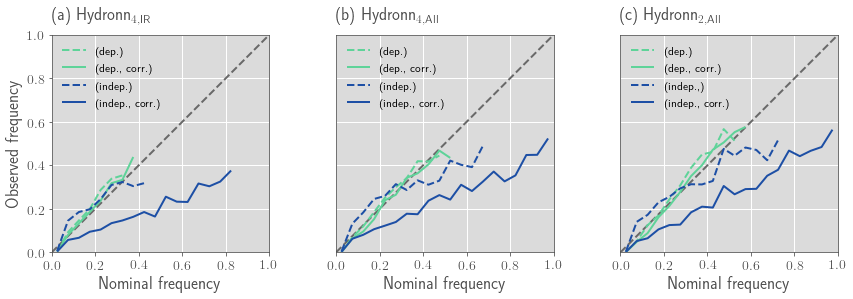

In [120]:
f = plt.figure(figsize=(15, 4))
gs = GridSpec(1, 3, wspace=0.06)
axs = [f.add_subplot(gs[i]) for i in range(3)]


#
# Hydronn 4 IR
#

THRESH = 5

ax = axs[0]
ax.set_title(r"(a) Hydronn$_{4, \text{IR}}$", loc="left")

x = np.linspace(0, 1, 21)
ax.plot(x, x, ls="--", c="dimgrey")

# dep.
x, y = calculate_calibration(h4_ir, "quantiles_dep", THRESH)
ax.plot(x, y, label= "(dep.)", c="C0", ls="--")

# dep. corr.
x, y = calculate_calibration(h4_ir, "quantiles_dep_c", THRESH)
ax.plot(x, y, label= "(dep., corr.)", c="C0")

# indep.
x, y = calculate_calibration(h4_ir, "quantiles_indep", THRESH)
ax.plot(x, y, label= "(indep.)", c="C1", ls="--")

# indep. corr.
x, y = calculate_calibration(h4_ir, "quantiles_indep_c", THRESH)
ax.plot(x, y, label= "(indep., corr.)", c="C1")
    
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect(1.0)
ax.set_ylabel("Observed frequency")
ax.set_xlabel("Nominal frequency")
ax.legend()


#
# Hydronn 4 All
#

ax = axs[1]
ax.set_title(r"(b) Hydronn$_{4, \text{All}}$", loc="left")
x = np.linspace(0, 1, 21)
ax.plot(x, x, ls="--", c="dimgrey")
# dep.
x, y = calculate_calibration(h4_all, "quantiles_dep", THRESH)
ax.plot(x, y, label= "(dep.)", c="C0", ls="--")
# dep. corr.
x, y = calculate_calibration(h4_all, "quantiles_dep_c", THRESH)
ax.plot(x, y, label= "(dep., corr.)", c="C0")
# indep.
x, y = calculate_calibration(h4_all, "quantiles_indep", THRESH)
ax.plot(x, y, label= "(indep.)", c="C1", ls="--")
# indep. corr.
x, y = calculate_calibration(h4_all, "quantiles_indep_c", THRESH)
ax.plot(x, y, label= "(indep., corr.)", c="C1")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect(1.0)
ax.set_xlabel("Nominal frequency")
ax.legend()

ax.set_yticklabels([])
for l in ax.yaxis.get_minorticklines():
    l.set_visible(False)
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)
    
#
# Hydronn 2 All
#

ax = axs[2]
ax.set_title(r"(c) Hydronn$_{2, \text{All}}$", loc="left")
x = np.linspace(0, 1, 21)
ax.plot(x, x, ls="--", c="dimgrey")
# dep.
x, y = calculate_calibration(h2, "quantiles_dep", THRESH)
ax.plot(x, y, label= "(dep.)", c="C0", ls="--")
# dep. corr.
x, y = calculate_calibration(h2, "quantiles_dep_c", THRESH)
ax.plot(x, y, label= "(dep., corr.)", c="C0")
# indep.
x, y = calculate_calibration(h2, "quantiles_indep", THRESH)
ax.plot(x, y, label= "(indep.,)", c="C1", ls="--")
# indep. corr.
x, y = calculate_calibration(h2, "quantiles_indep_c", THRESH)
ax.plot(x, y, label= "(indep., corr.)", c="C1")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect(1.0)
ax.set_xlabel("Nominal frequency")
ax.legend()

ax.set_yticklabels([])
for l in ax.yaxis.get_minorticklines():
    l.set_visible(False)
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)

f.savefig("../plots/classification_calibration.pdf")

## Case study

In [79]:
start_time = np.datetime64("2020-12-22T00:00:00")
end_time = np.datetime64("2020-12-24T00:00:00")
lat_xerem = -22.39
lon_xerem = -43.3

In [80]:
from hydronn.data.imerg import calculate_accumulations
imerg_c = calculate_accumulations("/home/simonpf/data_2/hydronn/GPM/",
                                  start=start_time,
                                  end=end_time )
imerg_c = imerg_c.transpose("latitude", "longitude")

In [123]:
from hydronn.data.persiann import calculate_accumulations
persiann_c = calculate_accumulations("/home/simonpf/data_2/hydronn/PERSIANN-CCS//",
                                     start=start_time,
                                     end=end_time )

2020-12-02T00:00:00
2020-12-02T01:00:00
2020-12-02T02:00:00
2020-12-02T03:00:00
2020-12-02T04:00:00
2020-12-02T05:00:00
2020-12-02T06:00:00
2020-12-02T07:00:00
2020-12-02T08:00:00
2020-12-02T09:00:00
2020-12-02T10:00:00
2020-12-02T11:00:00
2020-12-02T12:00:00
2020-12-02T13:00:00
2020-12-02T14:00:00
2020-12-02T15:00:00
2020-12-02T16:00:00
2020-12-02T17:00:00
2020-12-02T18:00:00
2020-12-02T19:00:00
2020-12-02T20:00:00
2020-12-02T21:00:00
2020-12-02T22:00:00
2020-12-02T23:00:00
2020-12-03T00:00:00
2020-12-03T01:00:00
2020-12-03T02:00:00
2020-12-03T03:00:00
2020-12-03T04:00:00
2020-12-03T05:00:00
2020-12-03T06:00:00
2020-12-03T07:00:00
2020-12-03T08:00:00
2020-12-03T09:00:00
2020-12-03T10:00:00
2020-12-03T11:00:00
2020-12-03T12:00:00
2020-12-03T13:00:00
2020-12-03T14:00:00
2020-12-03T15:00:00
2020-12-03T16:00:00
2020-12-03T17:00:00
2020-12-03T18:00:00
2020-12-03T19:00:00
2020-12-03T20:00:00
2020-12-03T21:00:00
2020-12-03T22:00:00
2020-12-03T23:00:00
2020-12-04T00:00:00
2020-12-04T01:00:00


2020-12-22T01:00:00
2020-12-22T02:00:00
2020-12-22T03:00:00
2020-12-22T04:00:00
2020-12-22T05:00:00
2020-12-22T06:00:00
2020-12-22T07:00:00
2020-12-22T08:00:00
2020-12-22T09:00:00
2020-12-22T10:00:00
2020-12-22T11:00:00
2020-12-22T12:00:00
2020-12-22T13:00:00
2020-12-22T14:00:00
2020-12-22T15:00:00
2020-12-22T16:00:00
2020-12-22T17:00:00
2020-12-22T18:00:00
2020-12-22T19:00:00
2020-12-22T20:00:00
2020-12-22T21:00:00
2020-12-22T22:00:00
2020-12-22T23:00:00
2020-12-23T00:00:00
2020-12-23T01:00:00
2020-12-23T02:00:00
2020-12-23T03:00:00
2020-12-23T04:00:00
2020-12-23T05:00:00
2020-12-23T06:00:00
2020-12-23T07:00:00
2020-12-23T08:00:00
2020-12-23T09:00:00
2020-12-23T10:00:00
2020-12-23T11:00:00
2020-12-23T12:00:00
2020-12-23T13:00:00
2020-12-23T14:00:00
2020-12-23T15:00:00
2020-12-23T16:00:00
2020-12-23T17:00:00
2020-12-23T18:00:00
2020-12-23T19:00:00
2020-12-23T20:00:00
2020-12-23T21:00:00
2020-12-23T22:00:00
2020-12-23T23:00:00
2020-12-24T00:00:00
2020-12-24T01:00:00
2020-12-24T02:00:00


In [124]:
persiann_c["longitude"] = persiann_c.longitude - 360

In [125]:
from hydronn.data.hydroestimator import calculate_accumulations
hydro_c = calculate_accumulations("/home/simonpf/Dendrite/UserAreas/Ingrid/HE/202012/",
                                  start=start_time,
                                  end=end_time )

2020-12-01T00:00:00
2020-12-01T00:10:00
2020-12-01T00:20:00
2020-12-01T00:30:00
2020-12-01T00:40:00
2020-12-01T00:50:00
2020-12-01T01:00:00
2020-12-01T01:10:00
2020-12-01T01:30:00
2020-12-01T01:40:00
2020-12-01T01:50:00
2020-12-01T02:00:00
2020-12-01T02:10:00
2020-12-01T02:20:00
2020-12-01T02:30:00
2020-12-01T02:40:00
2020-12-01T02:50:00
2020-12-01T03:00:00
2020-12-01T03:10:00
2020-12-01T03:20:00
2020-12-01T03:30:00
2020-12-01T03:40:00
2020-12-01T03:50:00
2020-12-01T04:00:00
2020-12-01T04:10:00
2020-12-01T04:20:00
2020-12-01T04:30:00
2020-12-01T04:40:00
2020-12-01T04:50:00
2020-12-01T05:00:00
2020-12-01T05:10:00
2020-12-01T05:20:00
2020-12-01T05:30:00
2020-12-01T05:40:00
2020-12-01T05:50:00
2020-12-01T06:00:00
2020-12-01T06:10:00
2020-12-01T06:20:00
2020-12-01T06:30:00
2020-12-01T06:40:00
2020-12-01T06:50:00
2020-12-01T07:00:00
2020-12-01T07:10:00
2020-12-01T07:20:00
2020-12-01T07:30:00
2020-12-01T07:40:00
2020-12-01T07:50:00
2020-12-01T08:00:00
2020-12-01T08:10:00
2020-12-01T08:20:00


2020-12-22T00:10:00
2020-12-22T00:20:00
2020-12-22T00:30:00
2020-12-22T00:40:00
2020-12-22T00:50:00
2020-12-22T01:00:00
2020-12-22T01:10:00
2020-12-22T01:20:00
2020-12-22T01:30:00
2020-12-22T01:40:00
2020-12-22T01:50:00
2020-12-22T02:00:00
2020-12-22T02:10:00
2020-12-22T02:20:00
2020-12-22T02:30:00
2020-12-22T02:40:00
2020-12-22T02:50:00
2020-12-22T03:00:00
2020-12-22T03:10:00
2020-12-22T03:20:00
2020-12-22T03:30:00
2020-12-22T03:40:00
2020-12-22T03:50:00
2020-12-22T04:00:00
2020-12-22T04:10:00
2020-12-22T04:20:00
2020-12-22T04:30:00
2020-12-22T04:40:00
2020-12-22T04:50:00
2020-12-22T05:00:00
2020-12-22T05:10:00
2020-12-22T05:20:00
2020-12-22T05:30:00
2020-12-22T05:40:00
2020-12-22T05:50:00
2020-12-22T06:00:00
2020-12-22T06:10:00
2020-12-22T06:20:00
2020-12-22T06:30:00
2020-12-22T06:40:00
2020-12-22T06:50:00
2020-12-22T07:00:00
2020-12-22T07:10:00
2020-12-22T07:20:00
2020-12-22T07:30:00
2020-12-22T07:40:00
2020-12-22T07:50:00
2020-12-22T08:00:00
2020-12-22T08:10:00
2020-12-22T08:20:00


In [126]:
hydro_c["surface_precip_acc"] = hydro_c["surface_precip_mean"] * 48

In [127]:
from hydronn.results import calculate_accumulations
h4_all_c = calculate_accumulations("/home/simonpf/data_2/hydronn/results/hydronn_4_all/2012",
                                   start=start_time,
                                   end=end_time )
h4_ir_c = calculate_accumulations("/home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012",
                                  start=start_time,
                                  end=end_time )
h2_c = calculate_accumulations("/home/simonpf/data_2/hydronn/results/hydronn_2/2012",
                               start=start_time,
                               end=end_time )

2020-12-01T00:00:00
2020-12-01T01:00:00
2020-12-01T02:00:00
2020-12-01T03:00:00
2020-12-01T04:00:00
2020-12-01T05:00:00
2020-12-01T06:00:00
2020-12-01T07:00:00
2020-12-01T08:00:00
2020-12-01T09:00:00
2020-12-01T10:00:00
2020-12-01T11:00:00
2020-12-01T12:00:00
2020-12-01T13:00:00
2020-12-01T14:00:00
2020-12-01T15:00:00
2020-12-01T16:00:00
2020-12-01T17:00:00
2020-12-01T18:00:00
2020-12-01T19:00:00
2020-12-01T20:00:00
2020-12-01T21:00:00
2020-12-01T22:00:00
2020-12-01T23:00:00
2020-12-02T00:00:00
2020-12-02T01:00:00
2020-12-02T02:00:00
2020-12-02T03:00:00
2020-12-02T04:00:00
2020-12-02T05:00:00
2020-12-02T06:00:00
2020-12-02T07:00:00
2020-12-02T08:00:00
2020-12-02T09:00:00
2020-12-02T10:00:00
2020-12-02T11:00:00
2020-12-02T12:00:00
2020-12-02T13:00:00
2020-12-02T14:00:00
2020-12-02T15:00:00
2020-12-02T16:00:00
2020-12-02T17:00:00
2020-12-02T18:00:00
2020-12-02T19:00:00
2020-12-02T20:00:00
2020-12-02T21:00:00
2020-12-02T22:00:00
2020-12-02T23:00:00
2020-12-03T00:00:00
2020-12-03T01:00:00


Output()

Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_23_16.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_22_00.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_22_08.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_22_16.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_23_00.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_23_08.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_23_17.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_22_01.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_22_17.nc.gz.
Done processing /home/simonp

2020-12-01T00:00:00
2020-12-01T01:00:00
2020-12-01T02:00:00
2020-12-01T03:00:00
2020-12-01T04:00:00
2020-12-01T05:00:00
2020-12-01T06:00:00
2020-12-01T07:00:00
2020-12-01T08:00:00
2020-12-01T09:00:00
2020-12-01T10:00:00
2020-12-01T11:00:00
2020-12-01T12:00:00
2020-12-01T13:00:00
2020-12-01T14:00:00
2020-12-01T15:00:00
2020-12-01T16:00:00
2020-12-01T17:00:00
2020-12-01T18:00:00
2020-12-01T19:00:00
2020-12-01T20:00:00
2020-12-01T21:00:00
2020-12-01T22:00:00
2020-12-01T23:00:00
2020-12-02T00:00:00
2020-12-02T01:00:00
2020-12-02T02:00:00
2020-12-02T03:00:00
2020-12-02T04:00:00
2020-12-02T05:00:00
2020-12-02T06:00:00
2020-12-02T07:00:00
2020-12-02T08:00:00
2020-12-02T09:00:00
2020-12-02T10:00:00
2020-12-02T11:00:00
2020-12-02T12:00:00
2020-12-02T13:00:00
2020-12-02T14:00:00
2020-12-02T15:00:00
2020-12-02T16:00:00
2020-12-02T17:00:00
2020-12-02T18:00:00
2020-12-02T19:00:00
2020-12-02T20:00:00
2020-12-02T21:00:00
2020-12-02T22:00:00
2020-12-02T23:00:00
2020-12-03T00:00:00
2020-12-03T01:00:00


Output()

Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_22_00.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_22_16.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_22_08.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_23_08.nc.gz.Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_23_16.nc.gz.

Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_23_00.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_22_01.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_22_17.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_22_09.nc.gz.
Done processing /home/simonpf/data_2/

2020-12-01T00:00:00
2020-12-01T01:00:00
2020-12-01T02:00:00
2020-12-01T03:00:00
2020-12-01T04:00:00
2020-12-01T05:00:00
2020-12-01T06:00:00
2020-12-01T07:00:00
2020-12-01T08:00:00
2020-12-01T09:00:00
2020-12-01T10:00:00
2020-12-01T11:00:00
2020-12-01T12:00:00
2020-12-01T13:00:00
2020-12-01T14:00:00
2020-12-01T15:00:00
2020-12-01T16:00:00
2020-12-01T17:00:00
2020-12-01T18:00:00
2020-12-01T19:00:00
2020-12-01T20:00:00
2020-12-01T21:00:00
2020-12-01T22:00:00
2020-12-01T23:00:00
2020-12-02T00:00:00
2020-12-02T01:00:00
2020-12-02T02:00:00
2020-12-02T03:00:00
2020-12-02T04:00:00
2020-12-02T05:00:00
2020-12-02T06:00:00
2020-12-02T07:00:00
2020-12-02T08:00:00
2020-12-02T09:00:00
2020-12-02T10:00:00
2020-12-02T11:00:00
2020-12-02T12:00:00
2020-12-02T13:00:00
2020-12-02T14:00:00
2020-12-02T15:00:00
2020-12-02T16:00:00
2020-12-02T17:00:00
2020-12-02T18:00:00
2020-12-02T19:00:00
2020-12-02T20:00:00
2020-12-02T21:00:00
2020-12-02T22:00:00
2020-12-02T23:00:00
2020-12-03T00:00:00
2020-12-03T01:00:00


Output()

Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_23_00.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_23_08.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_23_16.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_22_08.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_22_16.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_22_00.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_23_01.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_22_01.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_23_09.nc.gz.
Done processing /home/simonpf/data_2/hydronn/results/hydronn_2/2

In [128]:
h4_all_c = h4_all_c[{"time": 0}]
h4_ir_c = h4_ir_c[{"time": 0}]
h2_c = h2_c[{"time": 0}]

In [129]:
h4_all_c["surface_precip_acc"] = h4_all_c["mean_dep"]
h4_ir_c["surface_precip_acc"] = h4_ir_c["mean_dep"]
h2_c["surface_precip_acc"] = h2_c["mean_dep"]
h4_all_c["surface_precip_mean"] = h4_all_c["mean_dep"] / h4_all_c.attrs["files"]
h4_ir_c["surface_precip_mean"] = h4_ir_c["mean_dep"] / h4_ir_c.attrs["files"]
h2_c["surface_precip_mean"] = h2_c["mean_dep"] / h2_c.attrs["files"]

In [130]:
hydro_c.surface_precip_acc.max()

<xarray.DataArray 'surface_precip_acc' ()>
array(389.76666, dtype=float32)

/tmp/ipykernel_32564/4019550943.py:63: RuntimeWarning: invalid value encountered in true_divide
  bias = 100 * bias.data / (0.5 * (total_r.data + total.data))
/tmp/ipykernel_32564/4019550943.py:63: RuntimeWarning: invalid value encountered in true_divide
  bias = 100 * bias.data / (0.5 * (total_r.data + total.data))
/tmp/ipykernel_32564/4019550943.py:63: RuntimeWarning: invalid value encountered in true_divide
  bias = 100 * bias.data / (0.5 * (total_r.data + total.data))
/tmp/ipykernel_32564/4019550943.py:78: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(m_acc, cax=ax, label="Accumulated precipitation [$\si{\milli \meter}$]")
/tmp/ipykernel_32564/4019550943.py:82: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(Fa

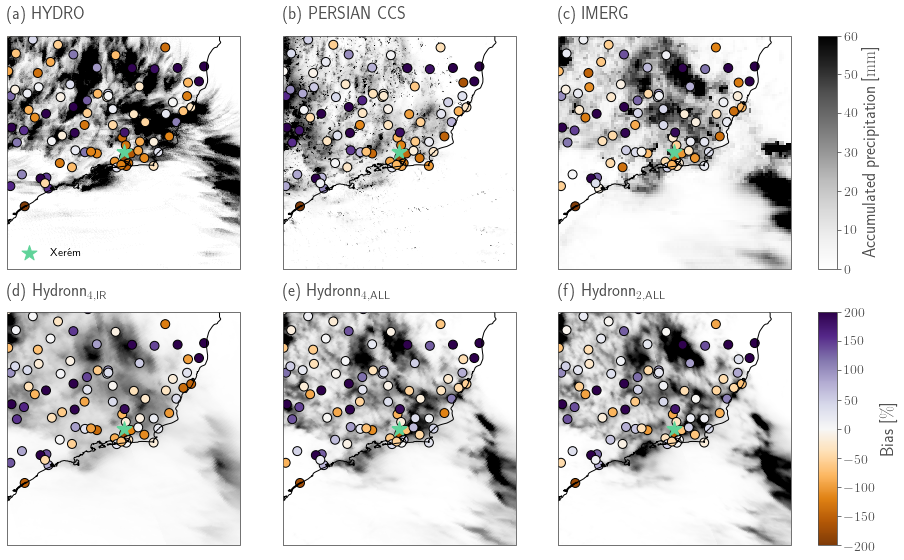

In [138]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

M = 2
N = 3
ccs = ccrs.PlateCarree()
f = plt.figure(figsize=(N * 4 + 1, M * 4))

gs = GridSpec(M, N + 1, width_ratios =  N * [1.0] + [0.075])
axs = np.array(
[[f.add_subplot(
    gs[i, j], projection=ccs) for j in range(N)] for i in range(M)]
)

levels = np.linspace(1, 60, 10)
norm = Normalize(0, 60)
bias_norm = Normalize(-200, 200)
cmap = cm.get_cmap("Greys")

data = {
    "HYDRO": (hydro, hydro_c),
    "PERSIAN CCS": (persiann, persiann_c),
    "IMERG": (imerg, imerg_c),
    r"Hydronn$_{4, \text{IR}}$": (h4_ir, h4_ir_c),
    r"Hydronn$_{4, \text{ALL}}$": (h4_all, h4_all_c),
    r"Hydronn$_{2, \text{ALL}}$": (h2, h2_c),
}

lat_min = np.array([d[1].latitude.min() for d in data.values()])
lat_max = np.array([d[1].latitude.max() for d in data.values()])
lon_min = np.array([d[1].longitude.min() for d in data.values()])
lon_max = np.array([d[1].longitude.max() for d in data.values()])

lat_min[lat_min > 180] -= 360
lat_max[lat_max > 180] -= 360
lon_min[lon_min > 180] -= 360
lon_max[lon_max > 180] -= 360

lat_min = lat_min.max()
lat_max = lat_max.min()
lon_min = lon_min.max()
lon_max = lon_max.min()

for i, (title, (precip, acc)) in enumerate(data.items()):
    
    ax = axs[i // N, i % N]
    
    # Plot accumulations as background
    lons = acc.longitude.data
    lats = acc.latitude.data
    sp = acc.surface_precip_acc.data
    m_acc = ax.pcolormesh(lons, lats, sp, norm=norm, cmap=cmap)
    ax.coastlines()

    # Scatter biases
    time_mask = (gauges.time >= start_time) * (gauges.time < end_time)
    sp_gauges = gauges.surface_precip[{"time": time_mask}]
    sp = precip.surface_precip.interp(time=sp_gauges.time)
    bias = (sp - sp_gauges).sum("time")
    total = sp_gauges.sum("time")
    total_r = sp.sum("time")
    bias = 100 * bias.data / (0.5 * (total_r.data + total.data))

    lons = gauges.longitude.data
    lats = gauges.latitude.data
    m_bias = ax.scatter(lons, lats, c=bias, norm=bias_norm, cmap="PuOr", s=80, edgecolor="k")
    ax.scatter([lon_xerem], [lat_xerem], marker="*", c="C0", s=250, label="Xerém")
    
    if i == 0:
        ax.legend(scatterpoints=1)
    
    ax.set_xlim([lon_xerem - 5, lon_xerem + 5])
    ax.set_ylim([lat_xerem - 5, lat_xerem + 5])
    ax.set_title(f"({chr(ord('a') + i)}) {title}", loc="left")

ax = f.add_subplot(gs[0, -1])
cb = plt.colorbar(m_acc, cax=ax, label="Accumulated precipitation [$\si{\milli \meter}$]")
cb.ax.set_facecolor((1.0, 1.0, 1.0, 1.0))

ax = f.add_subplot(gs[1, -1])
plt.colorbar(m_bias, cax=ax, label="Bias [$\si{\percent}$]")
plt.tight_layout()

f.savefig("../plots/accumulations_case.png", dpi=300)

In [83]:
d = ((np.cos(lat_xerem) * (gauges.latitude.data - lat_xerem)) ** 2 +
     (gauges.longitude.data - lon_xerem) ** 2)
gauge_index = np.argmin(d)

In [84]:
def plot_quantiles(ax, time, quantiles, color="C0"):
    for i in range(1, 7):
        alpha = 0.8 - i * 0.1
        upper = quantiles[:, 6 - (i - 1)]
        lower = quantiles[:, 6 - i]
        ax.fill_between(time, upper,lower, alpha=alpha, facecolor=color)
        
        upper = quantiles[:, 6 + i]
        lower = quantiles[:, 6 + i - 1]
        ax.fill_between(time, upper, lower, alpha=alpha, facecolor=color)

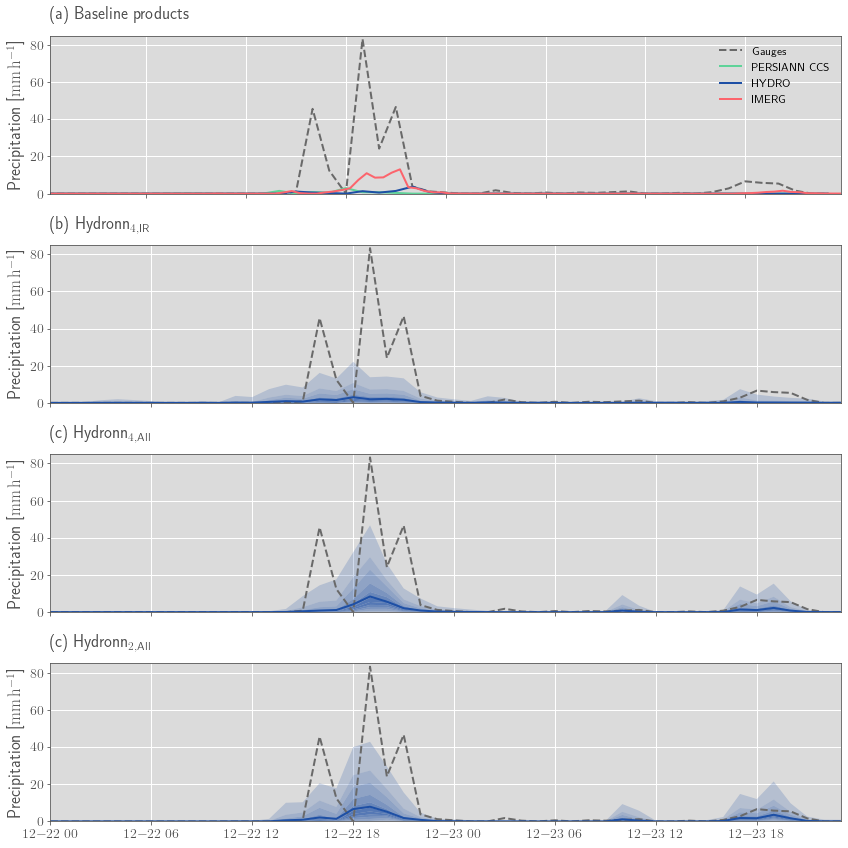

In [85]:
f, axs = plt.subplots(4, 1, figsize=(12, 12))

ax = axs[0]
data = {
    "PERSIANN CCS": persiann,
    "HYDRO": hydro,
    "IMERG": imerg
}

time_mask = ((gauges.time >= start_time) * (gauges.time < end_time))
sp = gauges[{"time": time_mask, "gauges": gauge_index}].surface_precip
ax.plot(sp.time, sp, label="Gauges", c="dimgrey", ls="--")

for name, results in data.items():
    time_mask = ((results.time >= start_time) * (results.time < end_time))
    sp = results[{"time": time_mask, "gauges": gauge_index}].surface_precip
    ax.plot(sp.time, sp, label=name)
    
ax.set_xticklabels([])
ax.set_ylim([0, 85])
ax.set_xlim([sp.time[0], sp.time[-1]])
ax.set_ylabel("Precipitation [$\si{\milli \meter \per \hour}$]")
ax.set_title("(a) Baseline products", loc="left")
ax.legend()

#
# Hydronn 4, IR
#

ax = axs[1]



time_mask = ((gauges.time >= start_time) * (gauges.time < end_time))
sp = gauges[{"time": time_mask, "gauges": gauge_index}].surface_precip
ax.plot(sp.time, sp, label="Gauges", c="dimgrey", ls="--")

time_mask = ((h4_ir.time >= start_time) * (h4_ir.time < end_time))
sp = h4_ir.mean_dep[{"time": time_mask, "gauges": gauge_index}]
ax.plot(sp.time, sp, c="C1", ls="-")
plot_quantiles(ax, sp.time, h4_ir.quantiles_dep[{"time": time_mask, "gauges": gauge_index}], color="C1")

ax.set_xticklabels([])
ax.set_ylim([0, 85])
ax.set_xlim([sp.time[0], sp.time[-1]])
ax.set_ylabel("Precipitation [$\si{\milli \meter \per \hour}$]")
ax.set_title(r"(b) Hydronn$_{4, \text{IR}}$", loc="left")

#
# Hydronn 4, All
#

ax = axs[2]
time_mask = ((gauges.time >= start_time) * (gauges.time < end_time))
sp = gauges[{"time": time_mask, "gauges": gauge_index}].surface_precip
ax.plot(sp.time, sp, label="Gauges", c="dimgrey", ls="--")

time_mask = ((h4_all.time >= start_time) * (h4_all.time < end_time))
sp = h4_all.mean_dep[{"time": time_mask, "gauges": gauge_index}]
ax.plot(sp.time, sp, c="C1", ls="-")
plot_quantiles(ax, sp.time, h4_all.quantiles_dep_c[{"time": time_mask, "gauges": gauge_index}], color="C1")

ax.set_xticklabels([])
ax.set_ylim([0, 85])
ax.set_xlim([sp.time[0], sp.time[-1]])
ax.set_ylabel("Precipitation [$\si{\milli \meter \per \hour}$]")
ax.set_title(r"(c) Hydronn$_{4, \text{All}}$", loc="left")

#
# Hydronn 2, All
#

ax = axs[3]
time_mask = ((gauges.time >= start_time) * (gauges.time < end_time))
sp = gauges[{"time": time_mask, "gauges": gauge_index}].surface_precip
ax.plot(sp.time, sp, label="Gauges", c="dimgrey", ls="--")

time_mask = ((h2.time >= start_time) * (h2.time < end_time))
sp = h2.mean_dep[{"time": time_mask, "gauges": gauge_index}]
ax.plot(sp.time, sp, c="C1", ls="-")
plot_quantiles(ax, sp.time, h2.quantiles_dep_c[{"time": time_mask, "gauges": gauge_index}], color="C1")

ax.set_ylim([0, 85])
ax.set_xlim([sp.time[0], sp.time[-1]])
ax.set_ylabel("Precipitation [$\si{\milli \meter \per \hour}$]")
ax.set_title(r"(c) Hydronn$_{2, \text{All}}$", loc="left")



plt.tight_layout()
f.savefig("../plots/case_study.pdf")

In [115]:
lat_xerem = -22.39
lon_xerem = -43.3
start_time_local = start_time + np.array([lon_xerem / 360 * 24 * 3600]).astype("timedelta64[s]")
end_time_local = end_time + np.array([lon_xerem / 360 * 24* 3600]).astype("timedelta64[s]")


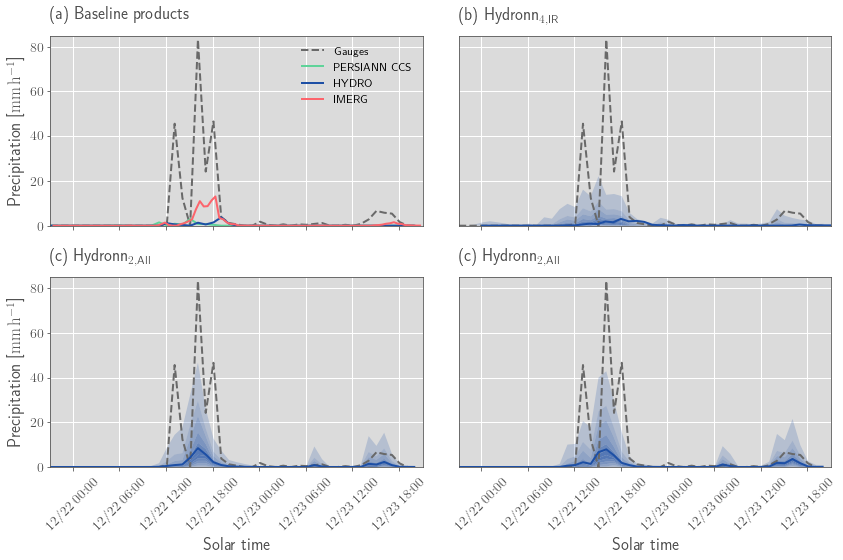

In [122]:
import matplotlib.dates as mdates
formatter = mdates.DateFormatter('%m/%d %H:%M')
f, axs = plt.subplots(2, 2, figsize=(12, 8))

ax = axs[0, 0]
data = {
    "PERSIANN CCS": persiann,
    "HYDRO": hydro,
    "IMERG": imerg
}

time_mask = ((gauges.time >= start_time) * (gauges.time < end_time))
sp = gauges[{"time": time_mask, "gauges": gauge_index}].surface_precip
local_time = sp.time + np.array([lon_xerem / 360 * 24* 3600]).astype("timedelta64[s]")
ax.plot(local_time, sp, label="Gauges", c="dimgrey", ls="--")

for name, results in data.items():
    time_mask = ((results.time >= start_time) * (results.time < end_time))
    sp = results[{"time": time_mask, "gauges": gauge_index}].surface_precip
    local_time = sp.time + np.array([(lon_xerem / 360 * 24 * 3600)]).astype("timedelta64[s]")
    ax.plot(local_time, sp, label=name)
    
ax.set_xticklabels([])
ax.set_ylim([0, 85])
ax.set_xlim([start_time_local, end_time_local])
ax.set_ylabel("Precipitation [$\si{\milli \meter \per \hour}$]")
ax.set_title("(a) Baseline products", loc="left")
ax.legend()

#
# Hydronn 4, IR
#

ax = axs[0, 1]



time_mask = ((gauges.time >= start_time) * (gauges.time < end_time))
sp = gauges[{"time": time_mask, "gauges": gauge_index}].surface_precip
local_time = sp.time + np.array([lon_xerem / 360 * 24 * 3600]).astype("timedelta64[s]")
ax.plot(local_time, sp, label="Gauges", c="dimgrey", ls="--")

time_mask = ((h4_ir.time >= start_time) * (h4_ir.time < end_time))
sp = h4_ir.mean_dep[{"time": time_mask, "gauges": gauge_index}]
local_time = sp.time + np.array([lon_xerem / 360 * 24 * 3600]).astype("timedelta64[s]")
ax.plot(sp.time, sp, c="C1", ls="-")
plot_quantiles(ax, local_time, h4_ir.quantiles_dep[{"time": time_mask, "gauges": gauge_index}], color="C1")

ax.set_xticklabels([])
ax.set_ylim([0, 85])
for l in ax.yaxis.get_ticklabels():
    l.set_visible(False)
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)
ax.set_xlim([start_time_local, end_time_local])
ax.set_title(r"(b) Hydronn$_{4, \text{IR}}$", loc="left")

#
# Hydronn 4, All
#

ax = axs[1, 0]
time_mask = ((gauges.time >= start_time) * (gauges.time < end_time))
sp = gauges[{"time": time_mask, "gauges": gauge_index}].surface_precip
local_time = sp.time + np.array([lon_xerem / 360 * 24 * 3600]).astype("timedelta64[s]")
ax.plot(local_time, sp, label="Gauges", c="dimgrey", ls="--")

time_mask = ((h4_all.time >= start_time) * (h4_all.time < end_time))
sp = h4_all.mean_dep[{"time": time_mask, "gauges": gauge_index}]
local_time = sp.time + np.array([lon_xerem / 360 * 24 * 3600]).astype("timedelta64[s]")
ax.plot(local_time, sp, c="C1", ls="-")
plot_quantiles(ax, local_time, h4_all.quantiles_dep_c[{"time": time_mask, "gauges": gauge_index}], color="C1")

ax.set_ylim([0, 85])
ax.set_xlim([start_time_local, end_time_local])
ax.set_title(r"(c) Hydronn$_{4, \text{All}}$", loc="left")

ax.set_ylim([0, 85])
ax.set_xlim([start_time_local, end_time_local])
ax.set_ylabel("Precipitation [$\si{\milli \meter \per \hour}$]")
ax.set_title(r"(c) Hydronn$_{2, \text{All}}$", loc="left")
ax.xaxis.set_major_formatter(formatter)

for l in ax.xaxis.get_ticklabels():
    l.set_rotation(45)
ax.set_xlabel("Solar time")

#
# Hydronn 2, All
#

ax = axs[1, 1]
time_mask = ((gauges.time >= start_time) * (gauges.time < end_time))
sp = gauges[{"time": time_mask, "gauges": gauge_index}].surface_precip
local_time = sp.time + np.array([lon_xerem / 360 * 24 * 3600]).astype("timedelta64[s]")
ax.plot(local_time, sp, label="Gauges", c="dimgrey", ls="--")

time_mask = ((h2.time >= start_time) * (h2.time < end_time))
sp = h2.mean_dep[{"time": time_mask, "gauges": gauge_index}]
local_time = sp.time + np.array([lon_xerem / 360 * 24 * 3600]).astype("timedelta64[s]")
ax.plot(local_time, sp, c="C1", ls="-")
plot_quantiles(ax, local_time, h2.quantiles_dep_c[{"time": time_mask, "gauges": gauge_index}], color="C1")

ax.set_ylim([0, 85])
ax.set_xlim([start_time_local, end_time_local])
for l in ax.yaxis.get_ticklabels():
    l.set_visible(False)
for l in ax.yaxis.get_ticklines():
    l.set_visible(False)
ax.set_title(r"(c) Hydronn$_{2, \text{All}}$", loc="left")
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel("Solar time")

for l in ax.xaxis.get_ticklabels():
    l.set_rotation(45)


plt.tight_layout()
f.savefig("../plots/case_study.pdf")

In [114]:
start_time_local

array(['2020-12-21T23:52:47'], dtype='datetime64[s]')

### Satellite observations

In [132]:
from pyresample import AreaDefinition
area = AreaDefinition(
    "xerem",
    "A region in Brazil.",
    "plate_carree",
    {"proj": "longlat", "ellps": "WGS84", "type": "crs"},
    400,
    400,
    [lon_xerem - 5, lat_xerem - 5, lon_xerem + 5, lat_xerem + 5]
)

In [14]:
from pathlib import Path
from pansat.products.satellite.goes import GOES16L1BRadiances
from datetime import datetime
from glob import glob
from satpy import Scene

if not Path("xerem_true_color.png").exists():
    goes = GOES16L1BRadiances("F", [1, 2, 3, 13])
    start_date = datetime(2020, 12, 22, 18, 0)
    files = goes.download(start_date, start_date)
    files = glob("GOES-16/GOES-16-ABI-L1b-RadF/*.nc")
    
    scene = Scene(files)
    scene.load(["true_color", "c13"])
    scene_r = scene.resample(area)
    scene_r.save_dataset("true_color", "xerem_true_color.png")
    scene_r.save_dataset("C13", "xerem_10um.png")

In [133]:
from glob import glob
from satpy import Scene
files = glob("GOES-16/GOES-16-ABI-L1b-RadF/*.nc")
scene = Scene(files)
scene.load(["true_color"])
scene_r = scene.resample(area)
scene_r.save_dataset("true_color", "brazil_tc.png")

satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: smos_l2_wind
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: mirs
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: amsr2_l2
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: olci_l2
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: mersi2_l1b
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: goes-imager_nc
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: jami_hrit
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: viirs_compact
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: electrol_hrit
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: msu_gsa_l1b
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: ami_l1b
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: mviri

In [16]:
from PIL import Image
xerem_tc = Image.open("xerem_true_color.png")

/tmp/ipykernel_8789/4195204444.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m, cax=ax, label="$\SI{10.7}{\micro \meter}$")


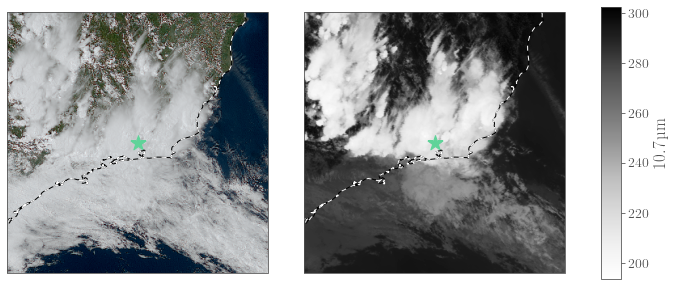

In [17]:
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature
f = plt.figure(figsize=(11, 5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])
crs = area.to_cartopy_crs()

ax = f.add_subplot(gs[0], projection=crs)
ext = area.area_extent
extent = [ext[0], ext[2], ext[1], ext[3]]
ax.imshow(xerem_tc, origin="upper", extent=extent)
ax.set_extent([ext[0], ext[2], ext[1], ext[3]], crs=crs)
ax.scatter([lon_xerem], [lat_xerem], marker="*", c="C0", s=250, label="Xerém")
ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.COASTLINE, edgecolor="w", ls=(0, (5, 5)))

ax = f.add_subplot(gs[1], projection=crs)
m = ax.imshow(xerem_10u, origin="upper", cmap="Greys", extent=extent)
ax.scatter([lon_xerem], [lat_xerem], marker="*", c="C0", s=250, label="Xerém")
ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.COASTLINE, edgecolor="w", ls=(0, (5, 5)))

ax = f.add_subplot(gs[2])
plt.colorbar(m, cax=ax, label="$\SI{10.7}{\micro \meter}$")

In [36]:
from hydronn.data.imerg import ImergFile
from hydronn.data.persiann import CCS
from hydronn.data.hydroestimator import load_file, Correction, get_lats_and_lons
ccs = CCS(1)
sp_persiann = ccs.open("/home/simonpf/data_2/hydronn/PERSIANN-CCS/rgccs1h2035717.bin.gz")
lons = sp_persiann.longitude.data
lats = sp_persiann.latitude.data
j_start, j_end = np.where((lons > (lon_xerem - 6 + 360)) * (lons < (lon_xerem + 6 + 360)))[0][[0, -1]]
i_start, i_end = np.where((lats > lat_xerem - 6) * (lats < lat_xerem + 6))[0][[0, -1]]
sp_persiann = sp_persiann[{"longitude": range(j_start, j_end), "latitude": range(i_start, i_end)}]

sp_imerg = ImergFile("/home/simonpf/data_2/hydronn/GPM/3B-HHR.MS.MRG.3IMERG.20201222-S180000-E182959.1080.V06B.HDF5").to_xarray_dataset()
lons = sp_imerg.longitude.data
lats = sp_imerg.latitude.data
j_start, j_end = np.where((lons > (lon_xerem - 6)) * (lons < (lon_xerem + 6)))[0][[0, -1]]
i_start, i_end = np.where((lats > lat_xerem - 6) * (lats < lat_xerem + 6))[0][[0, -1]]
sp_imerg = sp_imerg[{"longitude": range(j_start, j_end), "latitude": range(i_start, i_end)}]

correction = Correction("/home/simonpf/Dendrite/UserAreas/Ingrid/HE/zlookuptables/Lookuptable-2010-polygonclip-BRAZIL.txt")
sp_hydro = load_file("/home/simonpf/Dendrite/UserAreas/Ingrid/HE/202012/S11636382_202012221800.bin", correction=correction)
lats, lons = get_lats_and_lons()
sp_hydro = xr.Dataset({
    "longitude": (("longitude"), lons),
    "latitude": (("latitude"), lats),
    "surface_precip": (("latitude", "longitude"), sp_hydro),
})

In [37]:
from hydronn.utils import decompress_and_load
sp_h4_ir = decompress_and_load("/home/simonpf/data_2/hydronn/results/hydronn_4_ir/2012/hydronn_output_2020_12_22_18.nc.gz").rename({"mean_dep_c": "surface_precip"})
sp_h4_all = decompress_and_load("/home/simonpf/data_2/hydronn/results/hydronn_4_all/2012/hydronn_output_2020_12_22_18.nc.gz").rename({"mean_dep_c": "surface_precip"})
sp_h2 = decompress_and_load("/home/simonpf/data_2/hydronn/results/hydronn_2/2012/hydronn_output_2020_12_22_18.nc.gz").rename({"mean_dep_c": "surface_precip"})


In [38]:
sp_persiann.longitude.min(),  sp_persiann.longitude.max()

(<xarray.DataArray 'longitude' ()>
 array(310.74),
 <xarray.DataArray 'longitude' ()>
 array(322.62))

In [39]:
sp_persiann.longitude.size

298

/tmp/ipykernel_8789/1823648911.py:84: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m_bg, cax=ax, label="$\SI{10.7}{\micro \meter}$")


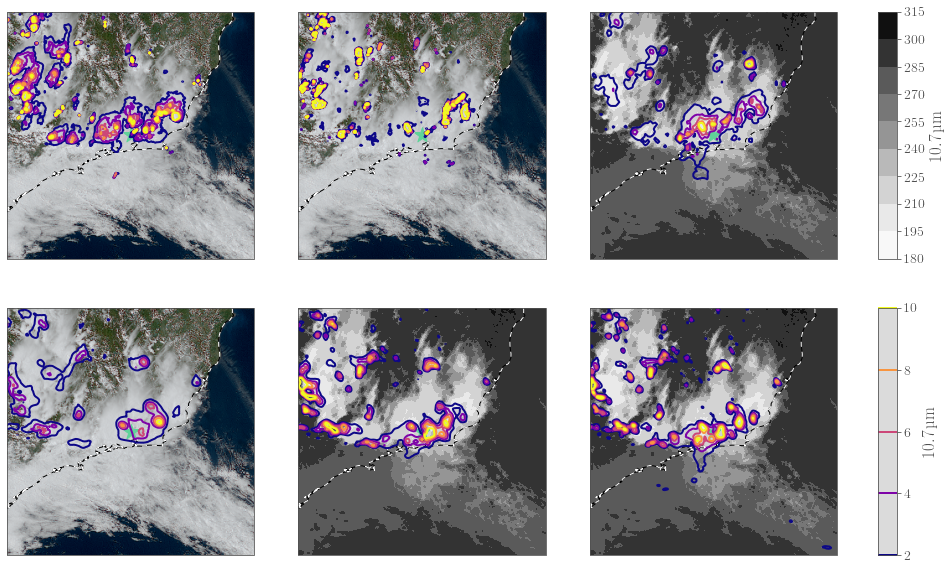

In [41]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature
f = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 4, width_ratios=[1.0, 1.0, 1.0, 0.075])
crs = area.to_cartopy_crs()

precip_norm = LogNorm(1e-1, 1e2)
precip_norm = Normalize(2, 10)
levels = np.linspace(0, 10, 6)[1:]

#
# Reference retrievals
#

ax = f.add_subplot(gs[0, 0], projection=crs)
ax.imshow(xerem_tc, origin="upper", extent=extent)
#m = ax.contourf(xerem_10u, origin="upper", cmap="Greys", extent=extent)
ax.scatter([lon_xerem], [lat_xerem], marker="*", c="C0", s=250, label="Xerém")
lons = sp_persiann.longitude.data
lats = sp_persiann.latitude.data
ax.contour(lons - 360, lats, np.maximum(sp_persiann.precipitation[0], 1e-2), cmap="plasma", norm=precip_norm, levels=levels)
ax.set_extent([ext[0], ext[2], ext[1], ext[3]], crs=crs)
ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.COASTLINE, edgecolor="w", ls=(0, (5, 5)))

ax = f.add_subplot(gs[0, 1], projection=crs)
#m = ax.contourf(xerem_10u, origin="upper", cmap="Greys", extent=extent)
ax.imshow(xerem_tc, origin="upper", extent=extent)
ax.scatter([lon_xerem], [lat_xerem], marker="*", c="C0", s=250, label="Xerém")
lons = sp_hydro.longitude.data
lats = sp_hydro.latitude.data
ax.contour(lons, lats, sp_hydro.surface_precip, cmap="plasma", norm=precip_norm, levels=levels)
ax.set_extent([ext[0], ext[2], ext[1], ext[3]], crs=crs)
ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.COASTLINE, edgecolor="w", ls=(0, (5, 5)))

ax = f.add_subplot(gs[0, 2], projection=crs)
m = ax.contourf(xerem_10u, origin="upper", cmap="Greys", extent=extent)
ax.scatter([lon_xerem], [lat_xerem], marker="*", c="C0", s=250, label="Xerém")
lons = sp_imerg.longitude.data
lats = sp_imerg.latitude.data
ax.contour(lons, lats, sp_imerg.surface_precip[0].T, cmap="plasma", norm=precip_norm, levels=levels)
ax.set_extent([ext[0], ext[2], ext[1], ext[3]], crs=crs)
ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.COASTLINE, edgecolor="w", ls=(0, (5, 5)))

#
# Hydronn
#

ax = f.add_subplot(gs[1, 0], projection=crs)
#m = ax.contourf(xerem_10u, origin="upper", cmap="Greys", extent=extent)
ax.imshow(xerem_tc, origin="upper", extent=extent)
ax.scatter([lon_xerem], [lat_xerem], marker="*", c="C0", s=250, label="Xerém")
lons = sp_h4_ir.longitude.data[0, ::2, ::2]
lats = sp_h4_ir.latitude.data[0, ::2, ::2]
ax.contour(lons, lats, np.maximum(sp_h4_ir.surface_precip[0], 1e-2), cmap="plasma", norm=precip_norm, levels=levels)
ax.set_extent([ext[0], ext[2], ext[1], ext[3]], crs=crs)
ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.COASTLINE, edgecolor="w", ls=(0, (5, 5)))

ax = f.add_subplot(gs[1, 1], projection=crs)
m_bg = ax.contourf(xerem_10u, origin="upper", cmap="Greys", extent=extent)
ax.scatter([lon_xerem], [lat_xerem], marker="*", c="C0", s=250, label="Xerém")
lons = sp_h4_all.longitude.data[0, ::2, ::2]
lats = sp_h4_all.latitude.data[0, ::2, ::2]
ax.contour(lons, lats, np.maximum(sp_h4_all.surface_precip[0], 1e-2), cmap="plasma", norm=precip_norm, levels=levels)
ax.set_extent([ext[0], ext[2], ext[1], ext[3]], crs=crs)
ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.COASTLINE, edgecolor="w", ls=(0, (5, 5)))

ax = f.add_subplot(gs[1, 2], projection=crs)
m = ax.contourf(xerem_10u, origin="upper", cmap="Greys", extent=extent)
ax.scatter([lon_xerem], [lat_xerem], marker="*", c="C0", s=250, label="Xerém")
lons = sp_h2.longitude.data[0]
lats = sp_h2.latitude.data[0]
m_p = ax.contour(lons, lats, np.maximum(sp_h2.surface_precip[0], 1e-2), cmap="plasma", norm=precip_norm, levels=levels)
ax.set_extent([ext[0], ext[2], ext[1], ext[3]], crs=crs)
ax.add_feature(cfeature.COASTLINE, edgecolor="k")
ax.add_feature(cfeature.COASTLINE, edgecolor="w", ls=(0, (5, 5)))

ax = f.add_subplot(gs[0, -1])
plt.colorbar(m_bg, cax=ax, label="$\SI{10.7}{\micro \meter}$")
ax = f.add_subplot(gs[1, -1])
plt.colorbar(m_p, cax=ax, label="$\SI{10.7}{\micro \meter}$")

In [134]:
from pyresample import AreaDefinition
from hydronn.definitions import ROI
area = AreaDefinition(
    "Brazil",
    "Overview of Brazil",
    "plate_carree",
    {"proj": "longlat", "ellps": "WGS84", "type": "crs"},
    1048,
    1048,
    ROI,
)

In [135]:
from glob import glob
from satpy import Scene
files = glob("GOES-16/GOES-16-ABI-L1b-RadF/*.nc")
scene = Scene(files)
scene.load(["true_color"])
scene_r = scene.resample(area)
scene_r.save_dataset("true_color", "brazil_tc.png")

satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: smos_l2_wind
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: mirs
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: amsr2_l2
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: olci_l2
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: mersi2_l1b
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: goes-imager_nc
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: jami_hrit
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: viirs_compact
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: electrol_hrit
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: msu_gsa_l1b
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: ami_l1b
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: mviri

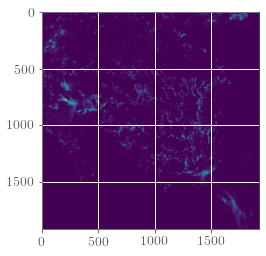

In [29]:
plt.imshow(sp_h2.surface_precip[0])hydronn.definitions

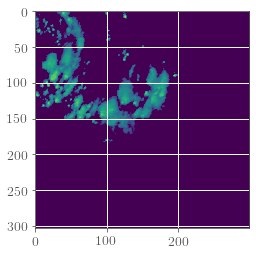

In [118]:
plt.imshow(np.maximum(sp_persiann.precipitation[0], 1e-2), norm=precip_norm)

In [102]:
sp_persiann.time

<xarray.DataArray 'time' (time: 1)>
array(['2020-12-22T18:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-12-22T18:00:00

In [95]:
from PIL import Image
rg = Image.load("xerem_true_color.png")

AttributeError: module 'PIL.Image' has no attribute 'load'

In [127]:
from pansat.products.satellite.persiann import CCS
ccs = CCS(1)
data = ccs.open("/home/simonpf/data_2/hydronn/PERSIANN-CCS/rgccs1h2035718.bin.gz")

In [128]:
data.time

<xarray.DataArray 'time' (time: 1)>
array(['2020-12-22T18:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-12-22T18:00:00

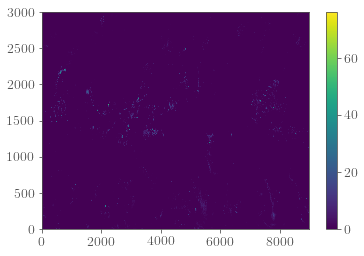

In [129]:
plt.pcolormesh(data.precipitation[0])
plt.colorbar()

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1543: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))


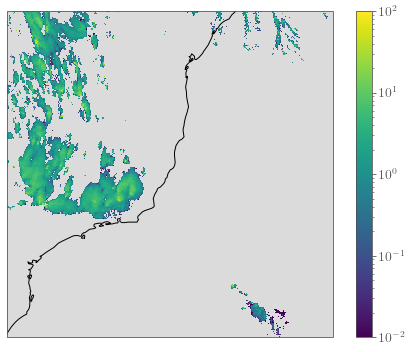

In [130]:
lons = data.longitude
lats = data.latitude
f = plt.figure(figsize=(8, 6))
ax = f.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
m = ax.pcolormesh(lons, lats, data.precipitation[0], norm=LogNorm(1e-2, 1e2))
ax.set_xlim([-50, -30])
ax.set_ylim([-30, -10])
ax.coastlines()
plt.colorbar(m)

In [131]:
data.precipitation.max()

<xarray.DataArray 'precipitation' ()>
array(76.24)

In [132]:
from hydronn.data.imerg import ImergFile
file = ImergFile("/home/simonpf/data_2/hydronn/GPM/3B-HHR.MS.MRG.3IMERG.20201222-S180000-E182959.1080.V06B.HDF5")
data = file.to_xarray_dataset()

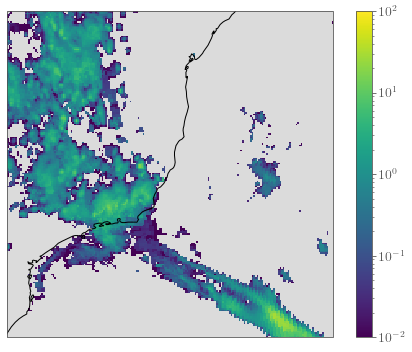

In [133]:
lons = data.longitude
lats = data.latitude
f = plt.figure(figsize=(8, 6))
ax = f.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
m = ax.pcolormesh(lons, lats, data.surface_precip[0].T, norm=LogNorm(1e-2, 1e2))
ax.set_xlim([-50, -30])
ax.set_ylim([-30, -10])
ax.coastlines()
plt.colorbar(m)